In [1]:
from functions import *

In [2]:
import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import *

**Analysing SN2010ev, in galaxy NGC 3244, which has redshift z=0.009213 ± 7.00e-6 (He)**

# Importing data

In [3]:
#import data
file_name="../SN2010ev.fits"
data = fits.open(file_name)
cube = data[1].data   # this is the cube, a (3681 x 341 x 604) matrix with fluxes at different 3681 wavelengths and 308 x 318 spatial pixels ("spaxels")
header = data[1].header # this has information on the data cube
ecube = data[2].data # this is the cube uncertainty (3681 x 341 x 604)
print(np.shape(cube))


print(cube[0])
print(cube[0][200][300])

x_len=len(cube[0][0])
y_len=len(cube[0])

(3681, 341, 604)
[[     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 ...
 [     nan      nan      nan ... 69.65055      nan      nan]
 [     nan      nan      nan ... 68.30897      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]]
91.866684


In [4]:
#  -- following is to the get the wavelength array
CRVAL = float(header["CRVAL3"])
NAXIS = int(header["NAXIS3"])
CDELT = float(header["CD3_3"])
CRPIX = float(header["CRPIX3"])
wave = np.array(CRVAL + CDELT * (np.arange(NAXIS) - CRPIX))

# Looking for stars

In [5]:
stacked_cube=stack_all(cube)

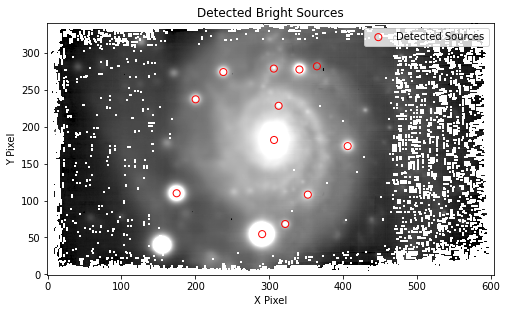

Source at: x=290.33, y=54.54
Source at: x=321.54, y=68.24
Source at: x=352.14, y=107.95
Source at: x=174.65, y=109.83
Source at: x=406.06, y=173.63
Source at: x=306.45, y=181.93
Source at: x=312.63, y=228.18
Source at: x=200.33, y=236.93
Source at: x=237.80, y=273.81
Source at: x=340.76, y=277.24
Source at: x=306.12, y=278.51
Source at: x=364.45, y=281.62


In [6]:
na_rest=5890

i=findWavelengths(wave, na_rest)[1]


image = stacked_cube#cube[i+3]

if image.ndim == 3:
    image = np.mean(image, axis=-1)

mean, median, std = sigma_clipped_stats(image, sigma=20.0)

# using DAOStarFinder to detect stars
daofind = DAOStarFinder(fwhm=14.0, threshold=3.0*std)
sources = daofind(image - median)

x_coords, y_coords = sources['xcentroid'], sources['ycentroid']

plt.figure(figsize=(8,6))
norm = simple_norm(image, 'sqrt')  # Better contrast
lo,up = np.nanpercentile(image,2),np.nanpercentile(image,98)
plt.imshow(image, cmap='gray', norm=norm, origin='lower',clim=(lo,up))
plt.scatter(x_coords, y_coords, s=50, edgecolor='red', facecolor='none', label="Detected Sources")
plt.legend()
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.title("Detected Bright Sources")
plt.show()

for x, y in zip(x_coords, y_coords):
    print(f"Source at: x={x:.2f}, y={y:.2f}")

finding ra,dec of center of image

In [7]:
wcs = WCS(data[1].header) 

center_x=int(x_len/2)
center_y=int(y_len/2)

ra, dec, _ = wcs.all_pix2world(center_x, center_y, 0, 0)

print(ra,dec)

156.37094651570212 -39.82809141441123


In [8]:
list(zip(x_coords, y_coords))
sources=list(zip(x_coords, y_coords))

sources = [[int(x) for x in row] for row in sources]
sources=np.array(sources)
sources=np.delete(sources, 1, axis=0)

#sources=sources[0:len(sources)-3]
print("The sources (x,y) are\n", sources)

The sources (x,y) are
 [[290  54]
 [352 107]
 [174 109]
 [406 173]
 [306 181]
 [312 228]
 [200 236]
 [237 273]
 [340 277]
 [306 278]
 [364 281]]


In [9]:
star_ra,star_dec,star_par,star_parer=match_gaia(sources,header,ra,dec)

[<SkyCoord (ICRS): (ra, dec) in deg
    [(156.3718138 , -39.83453593), (156.36732881, -39.83159106),
     (156.38020613, -39.83148069), (156.36342311, -39.82792389),
     (156.37065724, -39.82748028), (156.37022359, -39.82486913),
     (156.37832539, -39.82442511), (156.37564907, -39.82236948),
     (156.36819862, -39.82214671), (156.370658  , -39.82209139),
     (156.36646264, -39.8219243 )]>, <SpectralCoord 
   (target: <ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
                (156.380417, -39.8275, 1000.)
             (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
                (0., 0., 0.)>)
  [4.74969238e-07, 4.74969238e-07, 4.74969238e-07, 4.74969238e-07,
   4.74969238e-07, 4.74969238e-07, 4.74969238e-07, 4.74969238e-07,
   4.74969238e-07, 4.74969238e-07, 4.74969238e-07] m>]


HTTPError: OK

In [ ]:
star_ra

In [ ]:
out=gaia_parameters(star_ra,star_dec)

In [ ]:
from astropy.coordinates import Angle

ra_hms = Angle(ra, unit=u.deg).to_string(unit=u.hour, sep=':')
ra_hms;

Making a dataframe with data

In [ ]:
stars_data = pd.DataFrame({
    'x': sources[:,0],               # original image x
    'y': sources[:,1],               # original image y
    'ra': star_ra,                   # Right Ascension
    'dec': star_dec,                 # Declination
    'parallax': out[0],              # Parallax
    'parallax_err': out[1],          # Parallax error
    'teff': out[2],                  # Effective temperature
    'logg':out[3],                   # Surface gravity
    'met': out[4],                   # Metallicity
    'mag': out[5]                    # Mean magnitude in g-band
})


In [ ]:
stars_data = stars_data.dropna()
stars_data

# Na lines

In [9]:
na_rest

5890

5944.264569999999


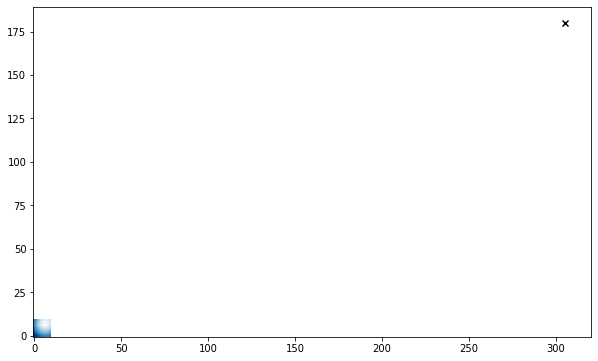

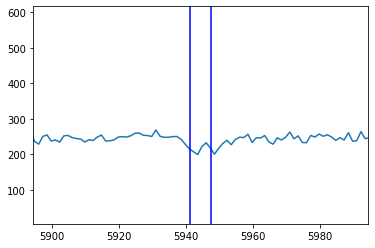

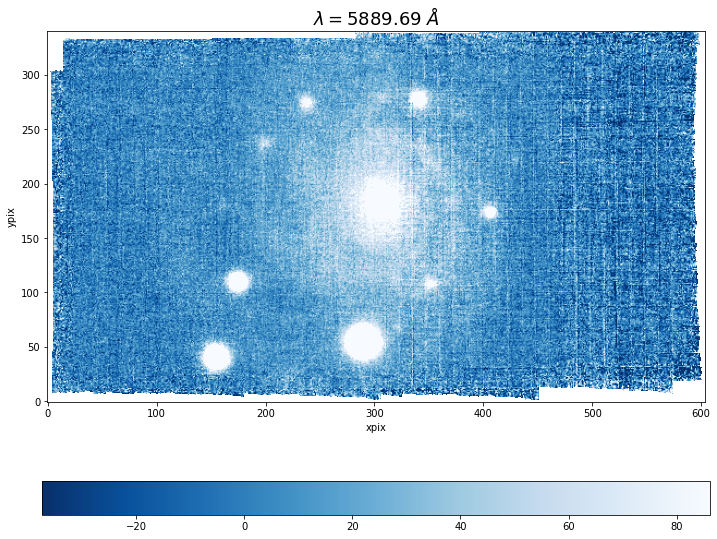

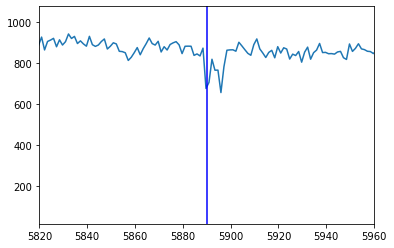

In [10]:
z=0.009213
na_obs=na_rest*(1+z)
print(na_obs)

wave_selection=[]

wavelen,index=findWavelengths(wave, na_rest)

y_pos=180#50#200
x_pos=305#290#300

x1=305-5#350
x2=305+5#470
y1=180-5#120
y2=180+5#200




image=stack_all(cube[:,y1:y2,x1:x2])#cube[index]
lo,up = np.nanpercentile(image,2),np.nanpercentile(image,98)
plt.figure(figsize=(10, 8))
plt.imshow(image,cmap='Blues_r',origin='lower',clim=(lo,up))
plt.scatter(x_pos,y_pos,marker='x',color='black')
plt.show()

####

plt.plot(wave, cube[:,y_pos,x_pos])
plt.xlim(na_obs-50,na_obs+50)
plt.axvline(x = 5893*(1+z), color = 'b', label = 'axvline - full height')

plt.axvline(x = 5887*(1+z), color = 'b', label = 'axvline - full height')
plt.show()

####
y_pos=40#200
x_pos=160#300
plot_image(cube[index],wavelen,index,'Blues_r')


plt.plot(wave, cube[:,y_pos,x_pos])
plt.xlim(5820,5960)#na_rest-50,na_rest+50)
plt.axvline(x = na_rest, color = 'b', label = 'axvline - full height')


# Picking region

In [11]:
y_pos=40#200
x_pos=160#300

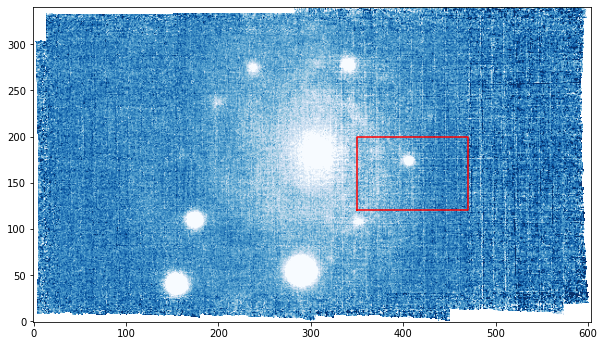

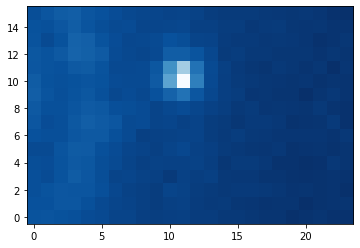

(16, 24)


In [12]:
x1=350
x2=470
y1=120
y2=200

"""x1=x_pos-30
x2=x_pos+100
y1=y_pos
y2=y_pos+130"""

region=cube[:,y1:y2,x1:x2]
region_err=ecube[:,y1:y2,x1:x2]
           
i=findWavelengths(wave, na_rest)[1]


lo,up = np.nanpercentile(cube[i],2),np.nanpercentile(cube[i],98)
plt.figure(figsize=(10, 8))
plt.imshow(cube[i],cmap='Blues_r',origin='lower',clim=(lo,up))


x_coords = [x1, x1, x2, x2, x1]
y_coords = [y1, y2, y2, y1, y1] 
plt.plot(x_coords, y_coords, 'r-', linewidth=1.5)  # Red outline

plt.show()

plt.imshow(binning(region[10], 5),"Blues_r",origin='lower');

plt.show()

print(np.shape(binning(region[10], 5)))

binned_region=[]
binned_region_err=[]

for w in range(0,len(wave)):
    binned_region.append(binning(region[w], 5))
    binned_region_err.append(binning(region_err[w], 5))
    
binned_region=np.array(binned_region)
binned_region_err=np.array(binned_region_err)

MUSE_err=np.sqrt(np.median(binned_region_err, axis=(1, 2)))

In [13]:
np.shape(binned_region)

(3681, 16, 24)

# EW

## EW - parametric

In [161]:
z=0.009213

na_obs=na_rest*(1+z)

In [162]:
na_obs

5944.264569999999

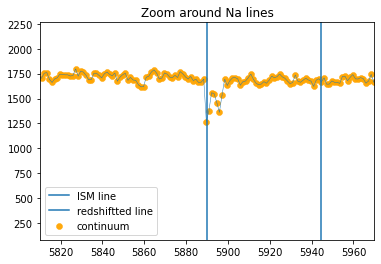

In [167]:
star_i=0
y_pos=sources[star_i][1]#40
x_pos=sources[star_i][0]#160

data=cube[:,y_pos,x_pos]

plt.plot(wave,data,linewidth=0.5,alpha=0.95)
plt.scatter(wave,data,s=0.5)

#plt.fill_between(wave,median_bulge - y_err, median_bulge + y_err, color='blue', alpha=0.3, label="Uncertainty")

x_min, x_max= plt.xlim(na_rest-80,na_rest+80)
plt.title("Zoom around Na lines")
x_chopped,y_chopped=chop_data(wave,data,x_min,x_max)

plt.axvline(x=na_rest,label="ISM line")
plt.axvline(x=na_obs,label="redshiftted line")

plt.scatter(x_chopped,y_chopped,linewidth=0.5,alpha=0.95,color="orange",label="continuum")
plt.legend()

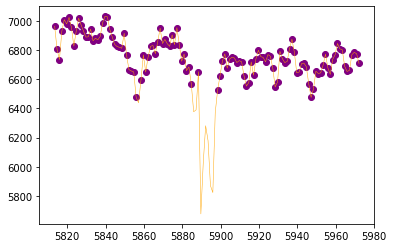

In [335]:
plt.plot(x_chopped,y_chopped,linewidth=0.5,alpha=0.95,color="orange",label="continuum")
#plt.ylim(300,1200)

x1,y1=filterout_peaks(x_chopped,y_chopped,mode="both")
plt.scatter(x1,y1,color="purple")

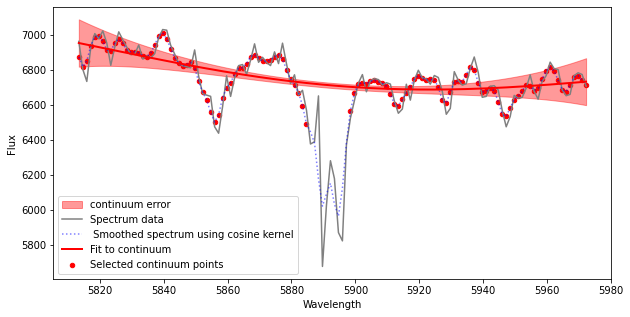

In [336]:
y_smooth=smooth_spectra(y_chopped,kernel_size=6)

continuum_fit, x_continuum, y_continuum, continuum_err =continuum(x_chopped,y_smooth,mode="both")

y_continuum_fit = continuum_fit(x_chopped)


cont_err=continuum_err(x_chopped)
plt.figure(figsize=(10, 5))
plt.fill_between(x_chopped,y_continuum_fit - cont_err, y_continuum_fit + cont_err, color='red', alpha=0.4, label="continuum error")
plt.plot(x_chopped, y_chopped, label="Spectrum data", color="gray")
plt.plot(x_chopped, y_smooth, label=" Smoothed spectrum using cosine kernel", color="blue", alpha=0.5,linestyle="dotted")
plt.plot(x_chopped, y_continuum_fit, label="Fit to continuum", color="red", linewidth=2)
plt.scatter(x_continuum, y_continuum, color="red", s=20, label="Selected continuum points")
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.legend()
#plt.xlim(6400,6500)
plt.show()

Fitting two gaussians

In [221]:
initial_guess = [2,0.5,200,na_rest,1,200,2,1,4.5]
params, covariance = curve_fit(two_gaussian_poly, x_chopped, y_smooth, p0=initial_guess)#input errors!

    
fit = lambda x: two_gaussian_poly(x,*params)

/home/rita13santos/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


!!!! lenx 128


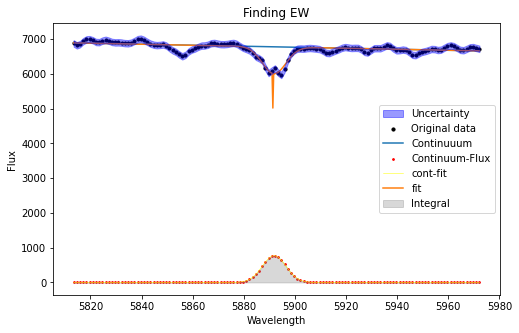

(1.3765630683054317, 0)

In [176]:
EW_parametric(x_chopped,y_smooth,MUSE_err,continuum_fit,continuum_err,method=1,plots=True,fit="Na", central_wavelength=na_rest)


In [138]:
na_rest

5890

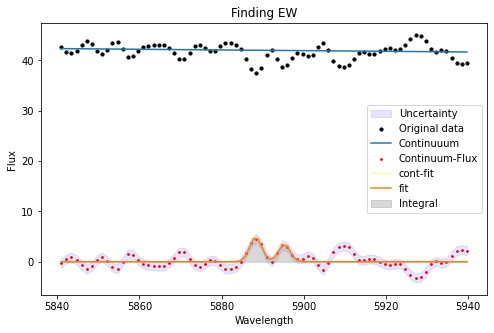

5840.9423828125 5939.6923828125
EW = 0.731  +/- 0.000  at (i,j)= 0 , 0


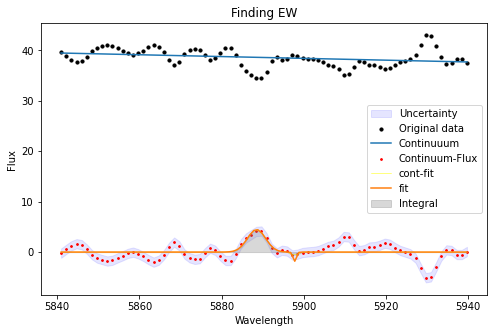

5840.9423828125 5939.6923828125
EW = 0.597  +/- 0.000  at (i,j)= 0 , 1


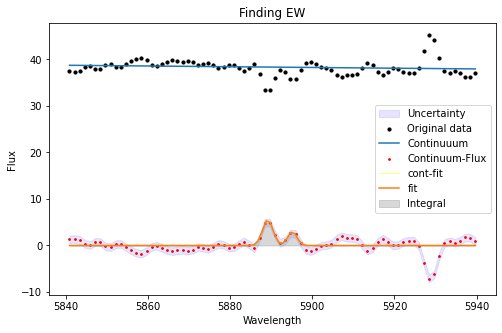

5840.9423828125 5939.6923828125
EW = 0.680  +/- 0.000  at (i,j)= 0 , 2


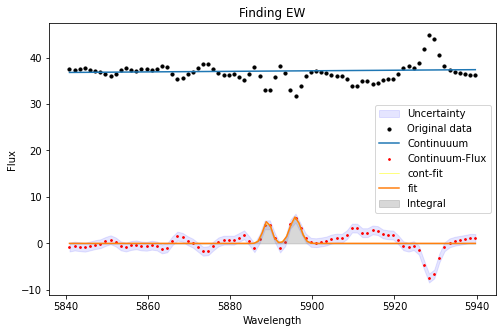

5840.9423828125 5939.6923828125
EW = 0.825  +/- 0.000  at (i,j)= 0 , 3


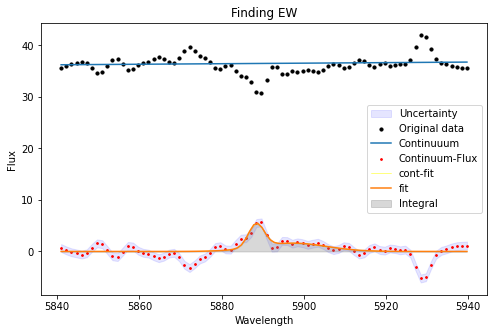

5840.9423828125 5939.6923828125
EW = 1.521  +/- 0.000  at (i,j)= 0 , 4


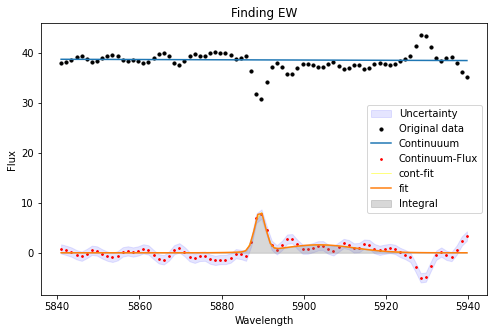

5840.9423828125 5939.6923828125
EW = 1.570  +/- 0.000  at (i,j)= 0 , 5


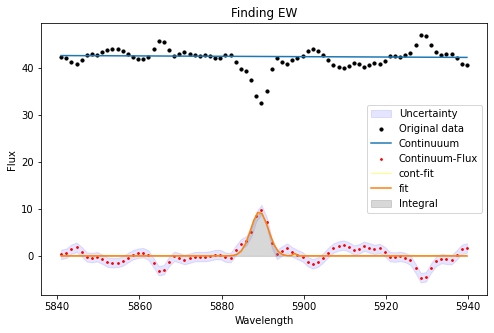

5840.9423828125 5939.6923828125
EW = 1.178  +/- 0.000  at (i,j)= 0 , 6



KeyboardInterrupt



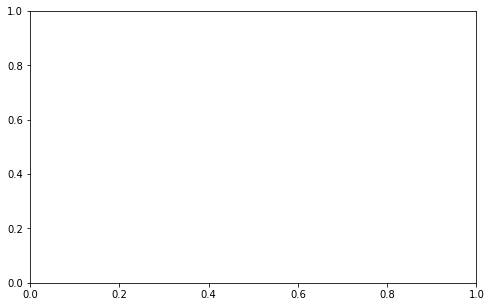

In [139]:
map_P=EW_map_parametric(binned_region,wave,MUSE_err,na_rest, method=0, fit="Na",mode="dips",kernel_size=6,plots=True)


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

data = np.transpose(map_P[0])
lo, up = np.nanpercentile(data, 2), np.nanpercentile(data, 98)
cmap = plt.cm.Blues_r.copy()
cmap.set_bad(color='yellow')
im1 = ax[0].imshow(data, cmap=cmap, origin='lower', clim=(lo, up))
fig.colorbar(im1, ax=ax[0], orientation="horizontal")
ax[0].set_title("EW (parametric approach)")

#####

data= np.transpose(abs(map_P[1]/map_P[0]))
lo, up = np.nanpercentile(data, 2), np.nanpercentile(data, 98)
im2 = ax[1].imshow(data, cmap=cmap, origin='lower', clim=(lo, up))
fig.colorbar(im2, ax=ax[1], orientation="horizontal")
ax[1].set_title(r"$\sigma_{\mathrm{EW}}/\mathrm{EW}$ (parametric approach)")

#####

data = binned_region[i]
lo, up = np.nanpercentile(data, 2), np.nanpercentile(data, 98)
im3 = ax[2].imshow(data, cmap='Blues_r', origin='lower', clim=(lo, up))
fig.colorbar(im3, ax=ax[2], orientation="horizontal")
ax[2].set_title("Fluxes")

plt.tight_layout()
plt.show()

## Non parametric

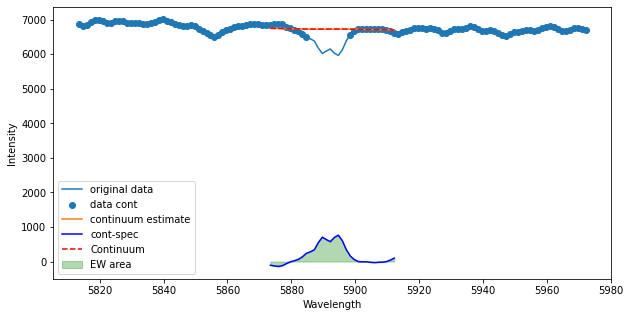

EW= 1.05  +/-  0.0858497769834649


In [337]:
EW_point_sources(cube, sources):

In [338]:
### velocity ###
rest_wave=wave/(1+z)

halpha=6563

b1=halpha-40
b2=halpha+40
x_chopped,y_chopped=chop_data(rest_wave,data,b1,b2)
                        

y_smooth=smooth_spectra(y_chopped,3)


x_cont,y_cont=filterout_peaks(x_chopped,y_smooth,"dips")
            
kernel = cosine_kernel(3)
cont = convolve1d(y_cont, kernel, mode='nearest')
interp=interp1d(x_cont, cont, kind='cubic')


v=velocity(x_chopped,y_chopped,interp,halpha)

print(f"Velocity from halpha = ",v)

Velocity from halpha =  140.52148764016061


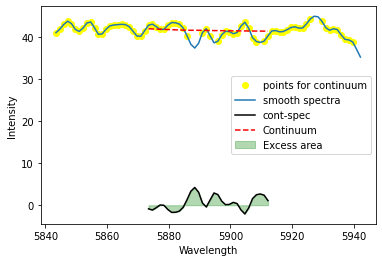

Integral of area over continuum divided by continuum: 0.565 +/- 0.090 at (i,j)= 0 ,  0


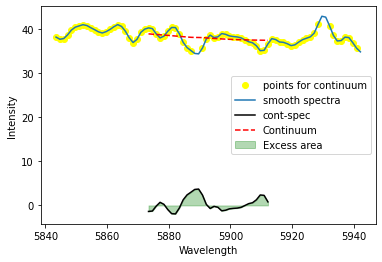

Integral of area over continuum divided by continuum: 0.383 +/- 0.072 at (i,j)= 0 ,  1


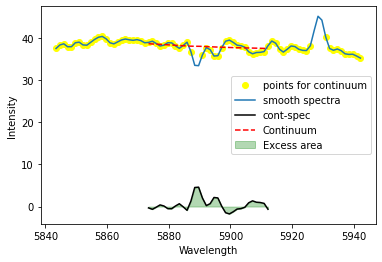

Integral of area over continuum divided by continuum: 0.499 +/- 0.072 at (i,j)= 0 ,  2


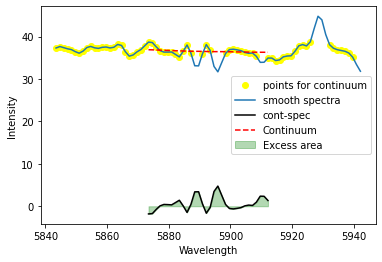

Integral of area over continuum divided by continuum: 0.724 +/- 0.060 at (i,j)= 0 ,  3


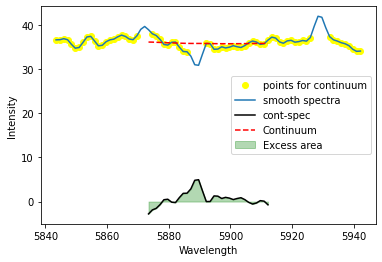

Integral of area over continuum divided by continuum: 0.746 +/- 0.055 at (i,j)= 0 ,  4


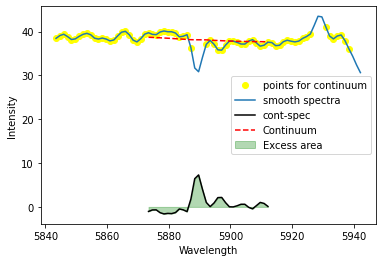

Integral of area over continuum divided by continuum: 0.615 +/- 0.084 at (i,j)= 0 ,  5


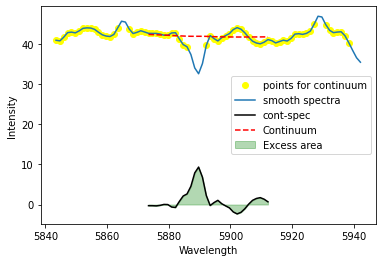

Integral of area over continuum divided by continuum: 0.991 +/- 0.072 at (i,j)= 0 ,  6


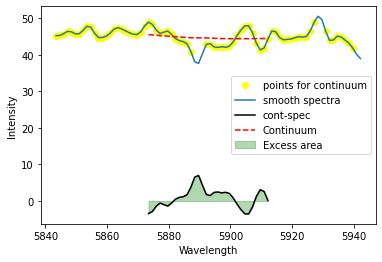

Integral of area over continuum divided by continuum: 0.776 +/- 0.114 at (i,j)= 0 ,  7


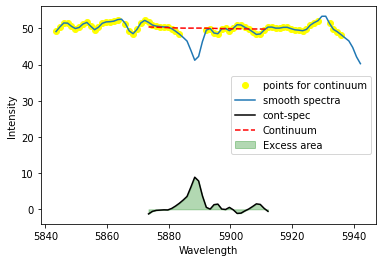

Integral of area over continuum divided by continuum: 0.961 +/- 0.049 at (i,j)= 0 ,  8


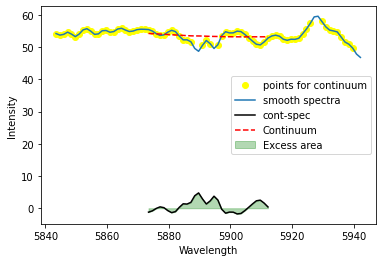

Integral of area over continuum divided by continuum: 0.520 +/- 0.078 at (i,j)= 0 ,  9


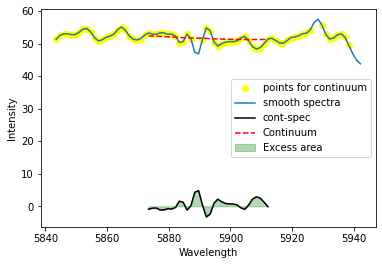

Integral of area over continuum divided by continuum: 0.367 +/- 0.081 at (i,j)= 0 ,  10


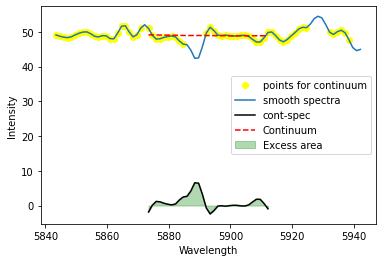

Integral of area over continuum divided by continuum: 0.780 +/- 0.039 at (i,j)= 0 ,  11


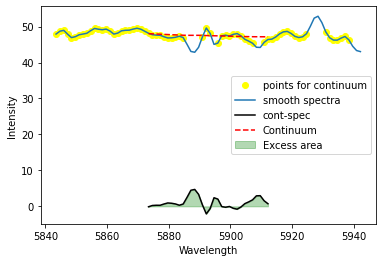

Integral of area over continuum divided by continuum: 0.838 +/- 0.047 at (i,j)= 0 ,  12


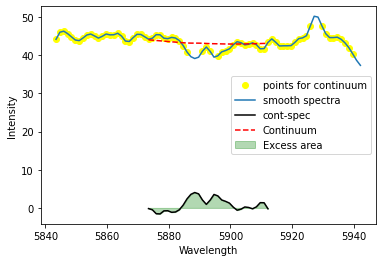

Integral of area over continuum divided by continuum: 0.748 +/- 0.099 at (i,j)= 0 ,  13


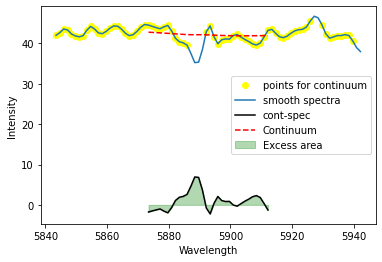

Integral of area over continuum divided by continuum: 0.932 +/- 0.094 at (i,j)= 0 ,  14


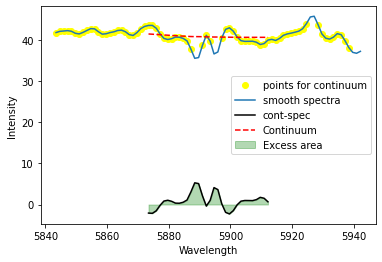

Integral of area over continuum divided by continuum: 0.829 +/- 0.054 at (i,j)= 0 ,  15


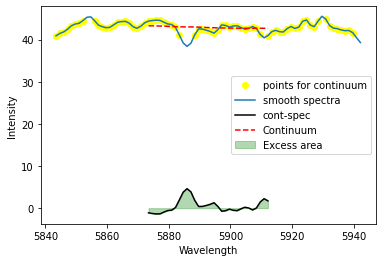

Integral of area over continuum divided by continuum: 0.457 +/- 0.057 at (i,j)= 1 ,  0


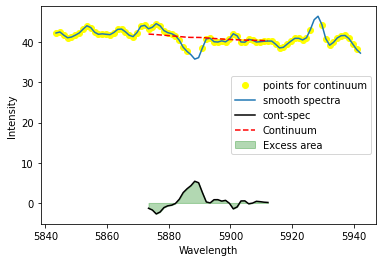

Integral of area over continuum divided by continuum: 0.508 +/- 0.059 at (i,j)= 1 ,  1


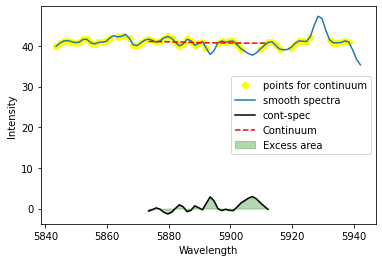

Integral of area over continuum divided by continuum: 0.485 +/- 0.047 at (i,j)= 1 ,  2


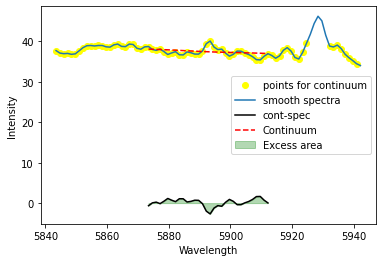

Integral of area over continuum divided by continuum: 0.189 +/- 0.034 at (i,j)= 1 ,  3


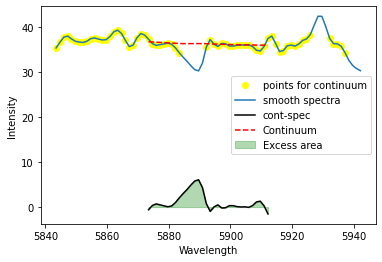

Integral of area over continuum divided by continuum: 1.253 +/- 0.033 at (i,j)= 1 ,  4


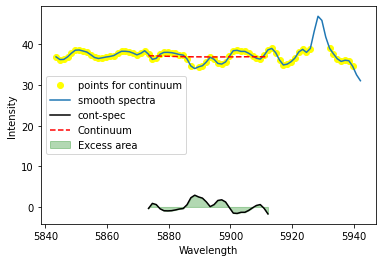

Integral of area over continuum divided by continuum: 0.210 +/- 0.062 at (i,j)= 1 ,  5


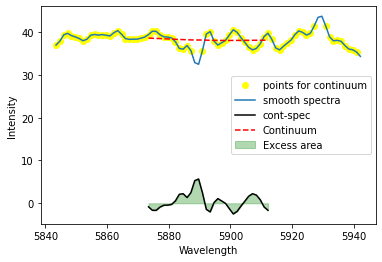

Integral of area over continuum divided by continuum: 0.452 +/- 0.107 at (i,j)= 1 ,  6


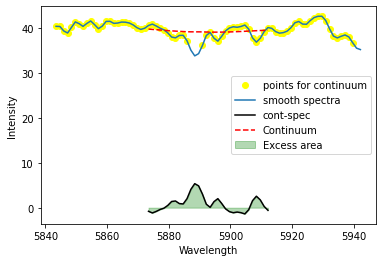

Integral of area over continuum divided by continuum: 0.837 +/- 0.093 at (i,j)= 1 ,  7


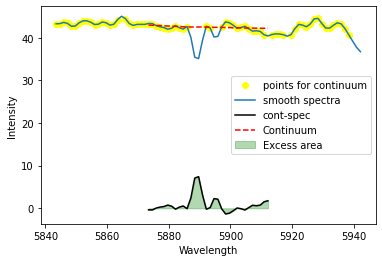

Integral of area over continuum divided by continuum: 0.808 +/- 0.040 at (i,j)= 1 ,  8


KeyboardInterrupt: 

In [93]:
map_NP=EW_map_non_parametric(binned_region,wave,na_rest,mode="both",kernel_size=60,plots=True)

In [78]:
i=findWavelengths(wave, na_rest)[1]

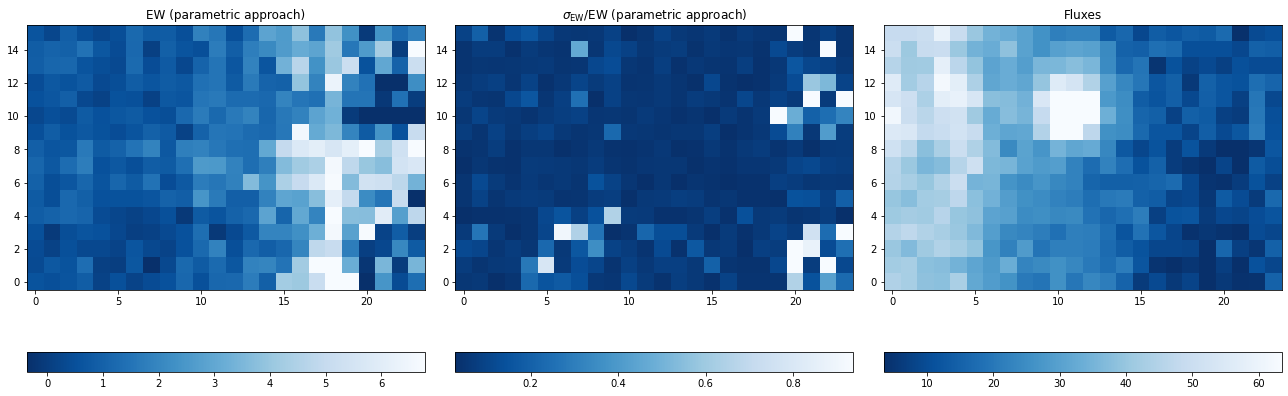

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

data = np.transpose(map_NP[0])
lo, up = np.nanpercentile(data, 2), np.nanpercentile(data, 98)
cmap = plt.cm.Blues_r.copy()
cmap.set_bad(color='yellow')
im1 = ax[0].imshow(data, cmap=cmap, origin='lower', clim=(lo, up))
fig.colorbar(im1, ax=ax[0], orientation="horizontal")
ax[0].set_title("EW (parametric approach)")

#####

data= np.transpose(abs(map_NP[1]/map_NP[0]))
lo, up = np.nanpercentile(data, 2), np.nanpercentile(data, 98)
im2 = ax[1].imshow(data, cmap=cmap, origin='lower', clim=(lo, up))
fig.colorbar(im2, ax=ax[1], orientation="horizontal")
ax[1].set_title(r"$\sigma_{\mathrm{EW}}/\mathrm{EW}$ (parametric approach)")

#####

data = binned_region[i]
lo, up = np.nanpercentile(data, 2), np.nanpercentile(data, 98)
im3 = ax[2].imshow(data, cmap='Blues_r', origin='lower', clim=(lo, up))
fig.colorbar(im3, ax=ax[2], orientation="horizontal")
ax[2].set_title("Fluxes")

plt.tight_layout()
plt.show()

# Computing Na for different point sources

Picking a list of positions to calculate Na EW instead of a map

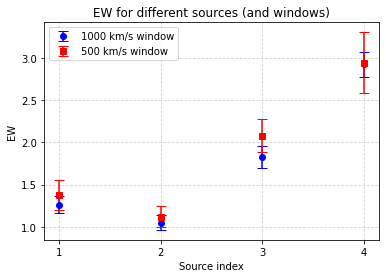

In [94]:


# Data for 1000 km/s window
ew_1000 = [1.26, 1.05, 1.83, 2.92]
err_1000 = [0.0999, 0.0858, 0.1298, 0.1517]

# Data for 500 km/s window
ew_500 = [1.38, 1.12, 2.08, 2.94]
err_500 = [0.1756, 0.1252, 0.1936, 0.3609]

x_pos = np.arange(len(ew_1000))

plt.errorbar(x_pos, ew_1000, yerr=err_1000, fmt='o', label="1000 km/s window", color='blue', capsize=5)
plt.errorbar(x_pos, ew_500, yerr=err_500, fmt='s', label="500 km/s window", color='red', capsize=5)

plt.xlabel("Source index")
plt.ylabel("EW")
plt.title("EW for different sources (and windows)")
plt.xticks(x_pos, ["1", "2", "3", "4"])  # Set x-ticks to match number of measurements
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


In [113]:
EWs,err=EW_point_sources(cube, sources, wave, na_rest)

EW= 1.28  +/-  0.12195453000660066
EW= 1.91  +/-  0.12668466602724626
EW= 2.87  +/-  0.17719872906283765
EW= -0.47  +/-  0.28549137330127394
EW= 1.48  +/-  0.19815736948623364
EW= 0.48  +/-  0.2862284226382247


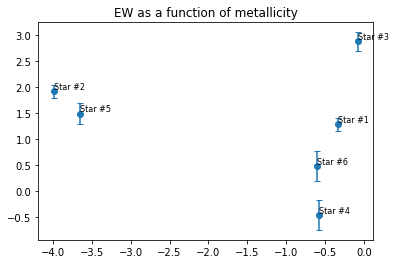

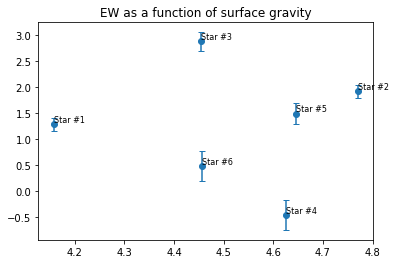

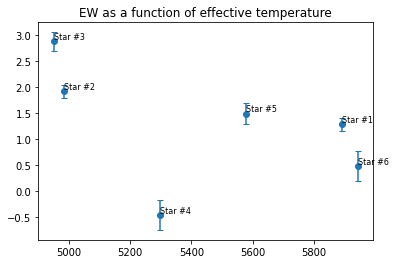

In [114]:
# out is (eff_t_array, surface_g_array, metallicity_array)

# Plot 1: EW vs Metallicity
plt.errorbar(out[-1], EWs, yerr=err, fmt='o', capsize=3)
plt.title("EW as a function of metallicity")
for i, (x, y) in enumerate(zip(out[-1], EWs), start=1):
    plt.text(x, y, f"Star #{i}", fontsize=8, ha='left', va='bottom')
plt.show()

# Plot 2: EW vs Surface Gravity
plt.errorbar(out[-2], EWs, yerr=err, fmt='o', capsize=3)
plt.title("EW as a function of surface gravity")
for i, (x, y) in enumerate(zip(out[-2], EWs), start=1):
    plt.text(x, y, f"Star #{i}", fontsize=8, ha='left', va='bottom')
plt.show()

# Plot 3: EW vs Effective Temperature
plt.errorbar(out[-3], EWs, yerr=err, fmt='o', capsize=3)
plt.title("EW as a function of effective temperature")
for i, (x, y) in enumerate(zip(out[-3], EWs), start=1):
    plt.text(x, y, f"Star #{i}", fontsize=8, ha='left', va='bottom')
plt.show()


In [115]:
print("metalicity ",out[-1])
print("\nsurface gravity log(g) ",out[-2])
print("\ntemperatures ",out[-3])

metalicity  [-0.33590001 -3.98620009 -0.0817     -0.5887     -3.6479001  -0.61070001]

surface gravity log(g)  [4.1573     4.77080011 4.45459986 4.62559986 4.64480019 4.45569992]

temperatures  [5891.31738281 4985.64111328 4950.34667969 5296.02050781 5579.58105469
 5944.46386719]


# plotting theoretical spectra

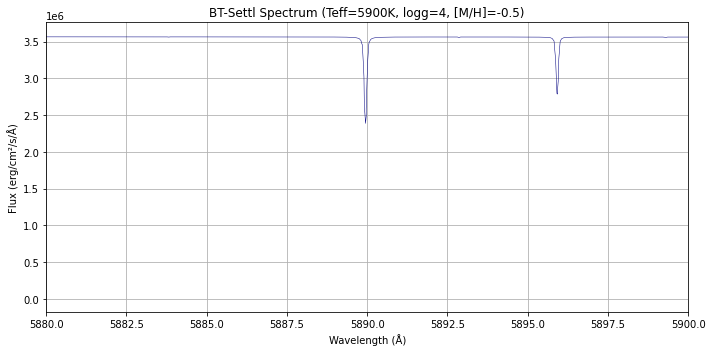

In [27]:
import numpy as np

# List of file paths
files = ["../DATA/teff5000_logg5_meta-4.txt",
    "../DATA/teff5900_logg4_meta-0.5.txt",
    "../DATA/teff5000_logg4.5_meta0.txt",
    "../DATA/teff5300_logg4.5_meta-0.5.txt",
    "../DATA/teff5600_logg4.5_meta-3.5.txt",
    "../DATA/teff5900_logg4.5_meta-0.5.txt"
]

spectra = []

for file_path in files:
    wavelength = []
    flux = []
    
    with open(file_path, "r") as file:
        for line in file:
            if line.strip().startswith("#") or line.strip() == "":
                continue
            parts = line.split()
            if len(parts) >= 2:
                wavelength.append(float(parts[0]))
                flux.append(float(parts[1]))
    
    wavelength = np.array(wavelength)
    flux = np.array(flux)
    
    spectra.append((wavelength, flux))

wavelength=spectra[0][0]
flux=spectra[0][1]
plt.figure(figsize=(10, 5))
plt.plot(wavelength, flux, color='navy',linewidth=0.5)
plt.title("BT-Settl Spectrum (Teff=5900K, logg=4, [M/H]=-0.5)")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (erg/cm²/s/Å)")
plt.grid(True)
#plt.xlim(min(wave),max(wave))
plt.xlim(na_rest-10,na_rest+10)
plt.tight_layout()
plt.show()

In [29]:
ew_theoretical=[]
err_ew_theoretical=[]
for (wavelength, flux) in spectra:
    val=EW_theoretical_spectra(wavelength, flux,na_rest)
    
    ew_theoretical.append(val[0][0])
    err_ew_theoretical.append(val[1][0])

EW= 0.06  +/-  0.00042596050390739435
EW= 0.66  +/-  0.002544189088064141
EW= 2.64  +/-  0.0385404361233365
EW= 1.32  +/-  0.0075571129372758415
EW= 0.08  +/-  0.0015555011549054753
EW= 0.72  +/-  0.0050415565509141546


In [149]:
print("The observed spectra EWs are:\n", EWs, "\nand the values from the theoretical spectra are \n",ew_theoretical)


The observed spectra EWs are:
 [1.2768084660521781, 1.9139914733013788, 2.873270285905287, -0.4694302462968602, 1.4836542843601261, 0.4820010169684891] 
and the values from the theoretical spectra are 
 [0.6563738648619779, 0.05938804063823471, 2.6408744690399644, 1.3180316264632566, 0.07596911767856192, 0.7220803181249915]


In [152]:
np.subtract(EWs,ew_theoretical)

array([ 0.6204346 ,  1.85460343,  0.23239582, -1.78746187,  1.40768517,
       -0.2400793 ])

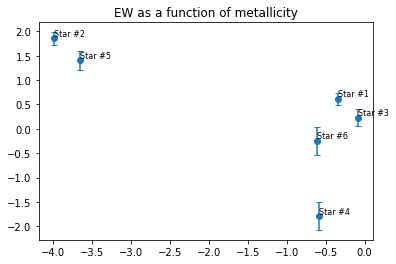

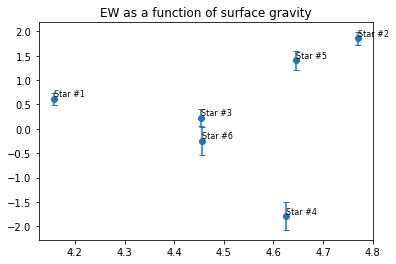

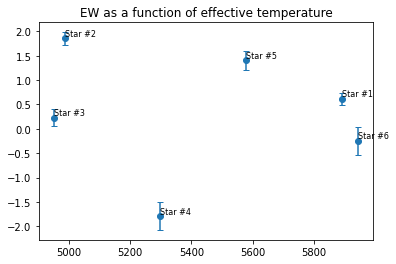

In [158]:
# out is (eff_t_array, surface_g_array, metallicity_array)

yy=np.subtract(EWs,ew_theoretical)

# Plot 1: EW vs Metallicity
plt.errorbar(out[-1], yy,yerr=err,fmt='o', capsize=3)
plt.title("EW as a function of metallicity")
for i, (x, y) in enumerate(zip(out[-1], yy), start=1):
    plt.text(x, y, f"Star #{i}", fontsize=8, ha='left', va='bottom')
plt.show()

# Plot 2: EW vs Surface Gravity
plt.errorbar(out[-2], yy, yerr=err, fmt='o', capsize=3)
plt.title("EW as a function of surface gravity")
for i, (x, y) in enumerate(zip(out[-2], yy), start=1):
    plt.text(x, y, f"Star #{i}", fontsize=8, ha='left', va='bottom')
plt.show()

# Plot 3: EW vs Effective Temperature
plt.errorbar(out[-3], yy, yerr=err, fmt='o', capsize=3)
plt.title("EW as a function of effective temperature")
for i, (x, y) in enumerate(zip(out[-3], yy), start=1):
    plt.text(x, y, f"Star #{i}", fontsize=8, ha='left', va='bottom')
plt.show()

# Fitting MUSE spectra to find Teff, metalicity and surface gravity

In [4]:
from species import SpeciesInit

# Initialize species
SpeciesInit()

species v0.8.4

 -> A new version (0.9.0) is available!
 -> It is recommended to update to the latest version
 -> See https://github.com/tomasstolker/species for details

Working folder: /home/rita13santos/PhD/extinction-ifs

Configuration file: /home/rita13santos/PhD/extinction-ifs/species_config.ini
Database file: /home/rita13santos/PhD/extinction-ifs/species_database.hdf5
Data folder: /home/rita13santos/PhD/extinction-ifs/data

Configuration settings:
   - Database: /home/rita13santos/PhD/extinction-ifs/species_database.hdf5
   - Data folder: /home/rita13santos/PhD/extinction-ifs/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py installed
Process number 1 out of 1...


In [5]:
import os
os.environ['DYLD_LIBRARY_PATH'] = '/Users/tomasstolker/applications/MultiNest/lib'

import urllib.request
from species import SpeciesInit
from species.data.database import Database
from species.fit.fit_model import FitModel
from species.read.read_model import ReadModel
from species.plot.plot_mcmc import plot_posterior
from species.plot.plot_spectrum import plot_spectrum
from species.util.box_util import update_objectbox
from species.util.fit_util import get_residuals, multi_photometry

In [6]:
from species.data.database import Database

database = Database()
database.add_model(model='drift-phoenix', teff_range=(1500., 2000.))



-------------------------
Add grid of model spectra
-------------------------

Database tag: drift-phoenix
Model name: DRIFT-PHOENIX



100%|███████████████████████████████████████| 113M/113M [00:00<00:00, 60.8GB/s]
SHA256 hash of downloaded file: b59b7711a4ed9dcf9284ef0c3f2b614598eec89bf53f548ceb361b806db70757
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.



Unpacking 140/496 model spectra from DRIFT-PHOENIX (229 MB)... [DONE]

Please cite Helling et al. (2008) when using DRIFT-PHOENIX in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2008ApJ...675L.105H

Wavelength range (um) = 0.1 - 50
Sampling (lambda/d_lambda) = 4000
Teff range (K) = 1500.0 - 2000.0

Adding DRIFT-PHOENIX model spectra... data/drift-phoenix/drift-phoenix_teff_2000_logg_5.5_feh_0.3_spec.npy 

Grid points stored in the database:
   - Teff = [1500. 1600. 1700. 1800. 1900. 2000.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]
   - [Fe/H] = [-0.6 -0.3 -0.   0.3]

Number of grid points per parameter:
   - teff: 6
   - logg: 6
   - feh: 4

Number of stored grid points: 144
Number of interpolated grid points: 0
Number of missing grid points: 0


In [61]:
star_i=0
y_pos=sources[star_i][1]#40
x_pos=sources[star_i][0]#160

data=cube[:,y_pos,x_pos]

"""valid_indices = ~(np.isnan(wave) | np.isnan(data))

# Filter out NaN values based on valid indices
x = wave[valid_indices]
y = data[valid_indices]

plt.plot(x,y)""";

In [85]:
na_rest

5890

In [88]:
x = wave
y = data
uncertainty = np.zeros(len(data))

# Stack x, y, and uncertainty together to form a (n_wavelengths, 3) array
spectrum_data = np.column_stack((x, y, uncertainty))

# Add the spectrum data to the database, making sure to provide the resolving power
database.add_object('my_object',
                    
                    app_mag=None,
                    flux_density=None,
                    spectrum={'GRAVITY': (spectrum_data, None, 50.0)},
                    deredden=None)




----------
Add object
----------

Object name: my_object
Units: None
Deredden: None

Spectra:
      - Database tag: GRAVITY
      - Data shape: (3681, 3)
      - Wavelength range (um): 4748.44 - 9348.44
      - Mean flux (W m-2 um-1): 1.44e+03
      - Mean error (W m-2 um-1): 0.00e+00
   - Instrument resolution:
      - GRAVITY: 50.0


In [83]:
fit = FitModel(object_name='my_object',
               model='bt-settl',
               bounds={'teff': (1500., 2000.),
                       'radius': (0.5, 2.),
                       'GPI_H': ((0.5, 1.5), None)},
               apply_weights=False,
               normal_prior={'mass': (9., 1.6)})




-----------------
Fit model spectra
-----------------



RuntimeError: Could not read the parallax of my_object. Please add the parallax with the add_object method of the Database class.

input resoluçao

resolucao e paralax é parametro livre? ou so input

In [27]:
spectrum_data = np.column_stack((wave, data))

# Create a PrimaryHDU object
hdu = fits.PrimaryHDU(spectrum_data)

# Add column info as header (optional but helpful)
hdu.header['TTYPE1'] = 'WAVELENGTH'
hdu.header['TTYPE2'] = 'FLUX'

# Write to file
hdu.writeto('../MUSEspectrum1.fits', overwrite=True)

# Using species to generate spectra

In [14]:
SpeciesInit()

species v0.8.4

 -> A new version (0.9.0) is available!
 -> It is recommended to update to the latest version
 -> See https://github.com/tomasstolker/species for details

Working folder: /home/rita13santos/PhD/extinction-ifs

Configuration file: /home/rita13santos/PhD/extinction-ifs/species_config.ini
Database file: /home/rita13santos/PhD/extinction-ifs/species_database.hdf5
Data folder: /home/rita13santos/PhD/extinction-ifs/data

Configuration settings:
   - Database: /home/rita13santos/PhD/extinction-ifs/species_database.hdf5
   - Data folder: /home/rita13santos/PhD/extinction-ifs/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py installed
Process number 1 out of 1...


In [15]:
database = Database()

In [16]:
_ = database.available_models()


-----------------------
Available model spectra
-----------------------

   - AMES-Cond:
      - Label = ames-cond
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [100, 6600]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 4000
      - File size: 150 MB

   - AMES-Dusty:
      - Label = ames-dusty
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [500, 4000]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 4000
      - File size: 58 MB

   - ATMO:
      - Label = atmo
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavelength range (um): [0.4, 6000]
      - Sampling (lambda/d_lambda): 1000
      - File size: 45 MB
      - Reference: Phillips et al. (2020)
      - URL: https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P

   - ATMO CEQ:
      - Label = atmo-ceq
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavele

In [ ]:
#stars_data

In [18]:
i=100
wave[i]/(wave[i+1]-wave[i])

3898.75390625

In [19]:
RES=20000
model_choice='phoenix-husser2013'#''bt-settl-cifist'

MUSE range is from 4700 to 9400 ang

which is equiv. to 0.47 to 0.94 um

In [20]:
import model_species
importlib.reload(model_species)

output = model_species.main(database, model_choice)
print(output)



-------------------------
Add grid of model spectra
-------------------------

Database tag: phoenix-husser2013
Model name: PHOENIX (Husser et al. 2013)

Unpacking 918/3920 model spectra from PHOENIX (Husser et al. 2013) (1.3 GB)... [DONE]

Model information: [alpha/Fe] = 0.0
Please cite Husser et al. (2013) when using PHOENIX (Husser et al. 2013) in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2013A%26A...553A...6H

Wavelength range (um) = 0.5 - 5
Sampling (lambda/d_lambda) = 5000
Teff range (K) = 4400 - 6000

Adding PHOENIX (Husser et al. 2013) model spectra... data/phoenix-husser2013/phoenix-husser2013_teff_6000_logg_5.5_feh_1.0_spec.npy 

Grid points stored in the database:
   - Teff = [4400. 4500. 4600. 4700. 4800. 4900. 5000. 5100. 5200. 5300. 5400. 5500.
 5600. 5700. 5800. 5900. 6000.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]
   - [Fe/H] = [-4.  -3.  -2.  -1.5 -1.  -0.5  0.   0.5  1. ]

Number of grid points per parameter:
   - teff: 17
   - logg: 6
   - feh: 9

In [21]:
model = ReadModel(model=model_choice, wavel_range=(0.47, 0.94))

In [22]:
model.get_bounds()
#stars_data

{'teff': (4400.0, 6000.0), 'logg': (3.0, 5.5), 'feh': (-4.0, 1.0)}

In [27]:
i=0

In [28]:
model_param = {'teff':stars_data.iloc[i]['teff'], 'logg':stars_data.iloc[i]['logg'], 'feh':stars_data.iloc[i]['met'], 'distance':1/stars_data.iloc[i]['parallax']}

In [29]:
model_box = model.get_model(model_param=model_param, spec_res=RES)

In [30]:
model_box.open_box()

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [31573921.2591066  31572629.18698421 31582222.86985505 ...
 21584678.96992834 21583024.67786606 21581413.33596934]
parameters = {'teff': 4985.64111328125, 'logg': 4.7708001136779785, 'feh': -3.9862000942230225, 'distance': 5.617748864906956}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000


In [31]:
model_param

{'teff': 4985.64111328125,
 'logg': 4.7708001136779785,
 'feh': -3.9862000942230225,
 'distance': 5.617748864906956}

In [32]:
model_ext = model.get_model(model_param=model_param, spec_res=RES)


-------------
Plot spectrum
-------------

Boxes:
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


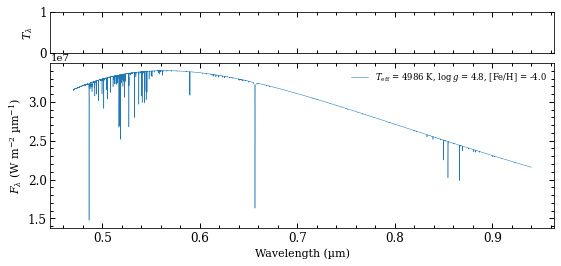

In [33]:
fig = plot_spectrum(boxes=[model_box],
                    filters=['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp'],
                    legend={'loc': 'upper right', 'frameon': False, 'fontsize': 8.5},
                    figsize=(7., 3.),
                    output=None)

In [34]:
b1,b2=(5890-30)*0.0001,(5896+30)*0.0001


-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


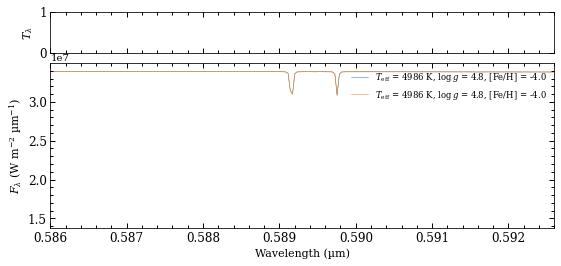

In [35]:
fig = plot_spectrum(boxes=[model_box, model_ext],
                    filters=['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp'],
                    xlim=(b1,b2),#ylim=(1.75*10**(-14),1.9*10**(-14)),
                    legend={'loc': 'upper right', 'frameon': False, 'fontsize': 8.5},
                    figsize=(7., 3.),
                    output=None)

In [36]:
model_box.open_box()

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [31573921.2591066  31572629.18698421 31582222.86985505 ...
 21584678.96992834 21583024.67786606 21581413.33596934]
parameters = {'teff': 4985.64111328125, 'logg': 4.7708001136779785, 'feh': -3.9862000942230225, 'distance': 5.617748864906956}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000


In [37]:
model_box.wavelength

array([0.46998894, 0.47001221, 0.47003548, ..., 0.93991401, 0.93996055,
       0.94000708])

In [38]:
xx=model_box.wavelength
xx=xx*10000
yy=model_box.flux

print(xx)
print(yy)

[4699.88937008 4700.12206359 4700.35476861 ... 9399.14011394 9399.60546933
 9400.07084776]
[31573921.2591066  31572629.18698421 31582222.86985505 ...
 21584678.96992834 21583024.67786606 21581413.33596934]


(5870.0, 5910.0)

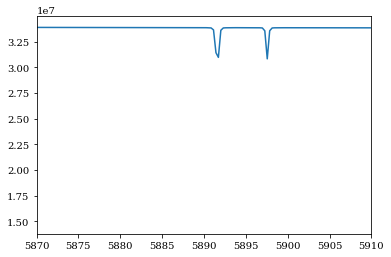

In [39]:
plt.plot(xx,yy)
plt.xlim(na_rest-20,na_rest+20)

In [40]:
spectra=[[xx,yy]]

In [41]:
ew_theoretical=[]
err_ew_theoretical=[]
for (wavelength, flux) in spectra:
    val=EW_theoretical_spectra(wavelength, flux,na_rest)
    
    ew_theoretical.append(val[0][0])
    err_ew_theoretical.append(val[1][0])

EW= 0.08  +/-  0.0008553373106328694


In [42]:
model_param

{'teff': 4985.64111328125,
 'logg': 4.7708001136779785,
 'feh': -3.9862000942230225,
 'distance': 5.617748864906956}

In [57]:
v=200
na_rest*(1-v/(3*10**5))

5886.073333333333

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [31573921.2591066  31572629.18698421 31582222.86985505 ...
 21584678.96992834 21583024.67786606 21581413.33596934]
parameters = {'teff': 4985.64111328125, 'logg': 4.7708001136779785, 'feh': -3.9862000942230225, 'distance': 5.617748864906956}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000
None

-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


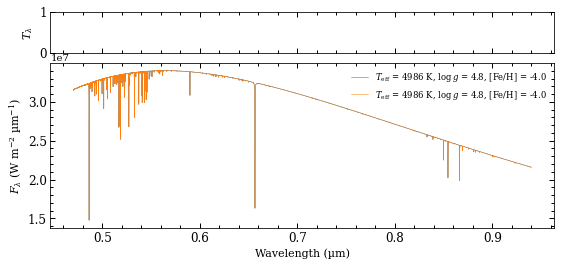

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [22923762.50606127 23062705.79613958 38583934.37901063 ...
 22612281.50571065 22504795.38459051 22137026.44946187]
parameters = {'teff': 4950.3466796875, 'logg': 4.454599857330322, 'feh': -0.08169999718666077, 'distance': 1.0499188676714757}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000
None

-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


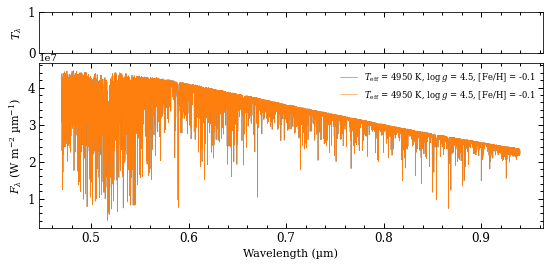

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [47225433.57297446 46819133.78235827 58694466.77550973 ...
 27968041.57288232 27984222.22944451 27844559.8063086 ]
parameters = {'teff': 5296.0205078125, 'logg': 4.6255998611450195, 'feh': -0.588699996471405, 'distance': 2.942284765848665}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000
None

-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


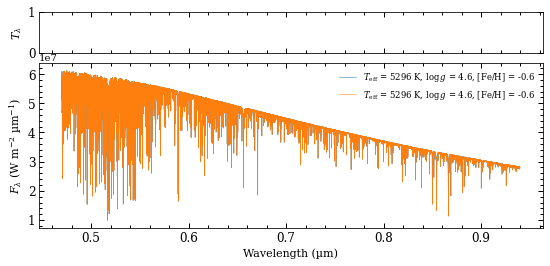

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [13370215.34325872 11288056.91250585 16856852.89201035 ...
 15059802.91134992 15075278.26860045 15050789.42461548]
parameters = {'teff': 4414.33740234375, 'logg': 4.717299938201904, 'feh': -1.0061999559402466, 'distance': 1.9813407267765526}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000
None

-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


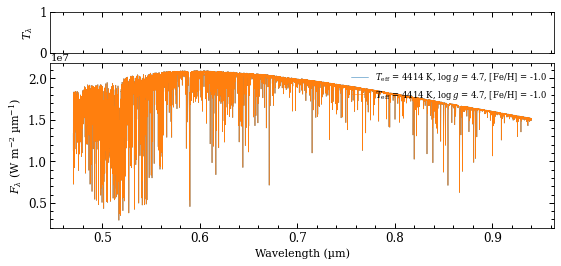

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [64327073.04937806 64331174.58254109 64352878.89332154 ...
 30451554.28034722 30448855.00524097 30446151.59621973]
parameters = {'teff': 5579.5810546875, 'logg': 4.644800186157227, 'feh': -3.647900104522705, 'distance': 4.886341799955745}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000
None

-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


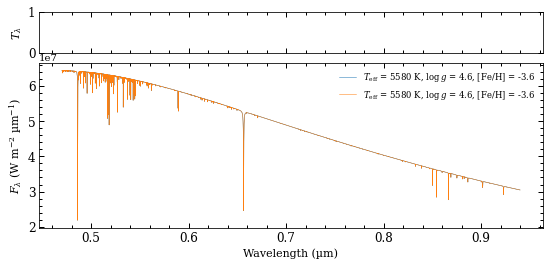

Opening ModelBox...
model = phoenix-husser2013
type = None
wavelength = [0.46998894 0.47001221 0.47003548 ... 0.93991401 0.93996055 0.94000708]
flux = [9.38305308e+07 9.79500442e+07 1.06626138e+08 ... 3.90986735e+07
 3.91968177e+07 3.91544350e+07]
parameters = {'teff': 5944.4638671875, 'logg': 4.455699920654297, 'feh': -0.6107000112533569, 'distance': 4.931472897812743}
quantity = flux
contribution = None
bol_flux = None
spec_res = 20000
None

-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


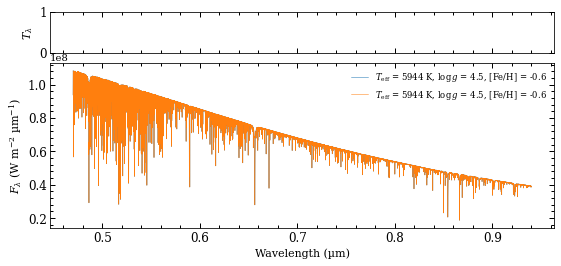

In [43]:
specs=generate_spectra(model,stars_data,figures=True)

In [44]:
stars_data

x    y          ra        dec  parallax  parallax_err         teff  \
1  352  107  156.366716 -39.831703  0.178007      0.139624  4985.641113   
2  174  109  156.379559 -39.831606  0.952455      0.031316  4950.346680   
3  406  173  156.362821 -39.828052  0.339872      0.069792  5296.020508   
6  200  236  156.377709 -39.824549  0.504709      0.110402  4414.337402   
7  237  273  156.375000 -39.822496  0.204652      0.095322  5579.581055   
8  340  277  156.367552 -39.822292  0.202779      0.051899  5944.463867   

     logg     met        mag  
1  4.7708 -3.9862  18.660872  
2  4.4546 -0.0817  15.921439  
3  4.6256 -0.5887  17.504930  
6  4.7173 -1.0062  18.284786  
7  4.6448 -3.6479  18.041954  
8  4.4557 -0.6107  16.939793

In [45]:
wavelength

array([4699.88937008, 4700.12206359, 4700.35476861, ..., 9399.14011394,
       9399.60546933, 9400.07084776])

In [51]:
na_rest

5890

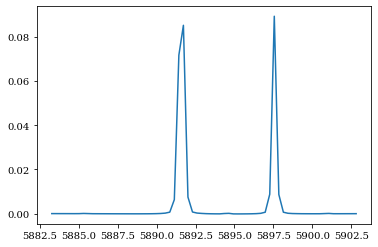

EW= 0.08  +/-  0.00038041001554278215


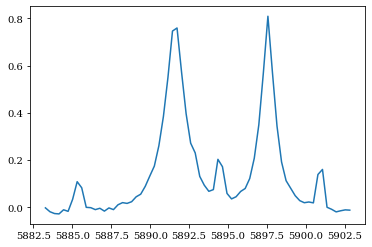

EW= 2.80  +/-  0.12085035179185742


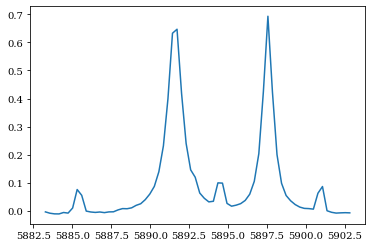

EW= 1.85  +/-  0.05631654188522047


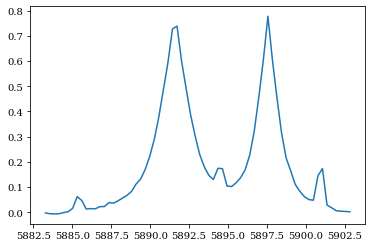

EW= 3.70  +/-  0.16846843668914713


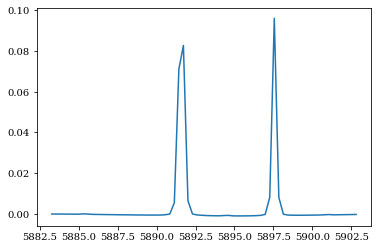

EW= 0.07  +/-  0.0014203595394948775


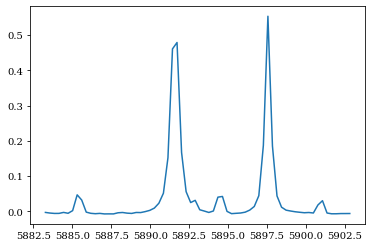

EW= 0.75  +/-  0.013641202369371216


In [69]:
ew_theoretical=[]
err_ew_theoretical=[]
for (wavelength, flux) in specs:
    val=EW_theoretical_spectra(wavelength*10000, flux,5893,plots=True)
    
    ew_theoretical.append(val[0][0])
    err_ew_theoretical.append(val[1][0])

In [70]:
stars_data['EW'] = ew_theoretical
stars_data['EW_err'] = err_ew_theoretical

In [71]:
stars_data

x    y          ra        dec  parallax  parallax_err         teff  \
1  352  107  156.366716 -39.831703  0.178007      0.139624  4985.641113   
2  174  109  156.379559 -39.831606  0.952455      0.031316  4950.346680   
3  406  173  156.362821 -39.828052  0.339872      0.069792  5296.020508   
6  200  236  156.377709 -39.824549  0.504709      0.110402  4414.337402   
7  237  273  156.375000 -39.822496  0.204652      0.095322  5579.581055   
8  340  277  156.367552 -39.822292  0.202779      0.051899  5944.463867   

     logg     met        mag        EW    EW_err  
1  4.7708 -3.9862  18.660872  0.081006  0.000380  
2  4.4546 -0.0817  15.921439  2.802039  0.120850  
3  4.6256 -0.5887  17.504930  1.845317  0.056317  
6  4.7173 -1.0062  18.284786  3.703291  0.168468  
7  4.6448 -3.6479  18.041954  0.072894  0.001420  
8  4.4557 -0.6107  16.939793  0.750240  0.013641

Text(0, 0.5, 'EW (from generated spec)')

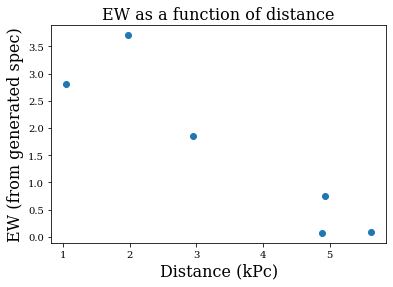

In [72]:
plt.scatter(1/stars_data['parallax'].values,stars_data['EW'].values)
plt.title("EW as a function of distance",fontsize=16)
plt.xlabel("Distance (kPc)",fontsize=16)
plt.ylabel("EW (from generated spec)",fontsize=16)

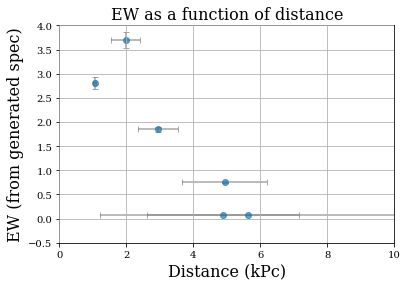

[0.00038041 0.12085035 0.05631654 0.16846844 0.00142036 0.0136412 ]


In [73]:
distance = 1 / stars_data['parallax'].values
ew = stars_data['EW'].values
distance_uncertainty = (stars_data['parallax_err'].values / stars_data['parallax'].values**2)

plt.errorbar(distance, ew, xerr=distance_uncertainty,yerr=stars_data['EW_err'].values, fmt='o', ecolor='gray', alpha=0.7, capsize=3)
plt.title("EW as a function of distance", fontsize=16)
plt.xlabel("Distance (kPc)", fontsize=16)
plt.ylabel("EW (from generated spec)", fontsize=16)
plt.grid(True)
plt.xlim(0,10)
plt.ylim(-0.5,4)
plt.show()

print(stars_data['EW_err'].values)

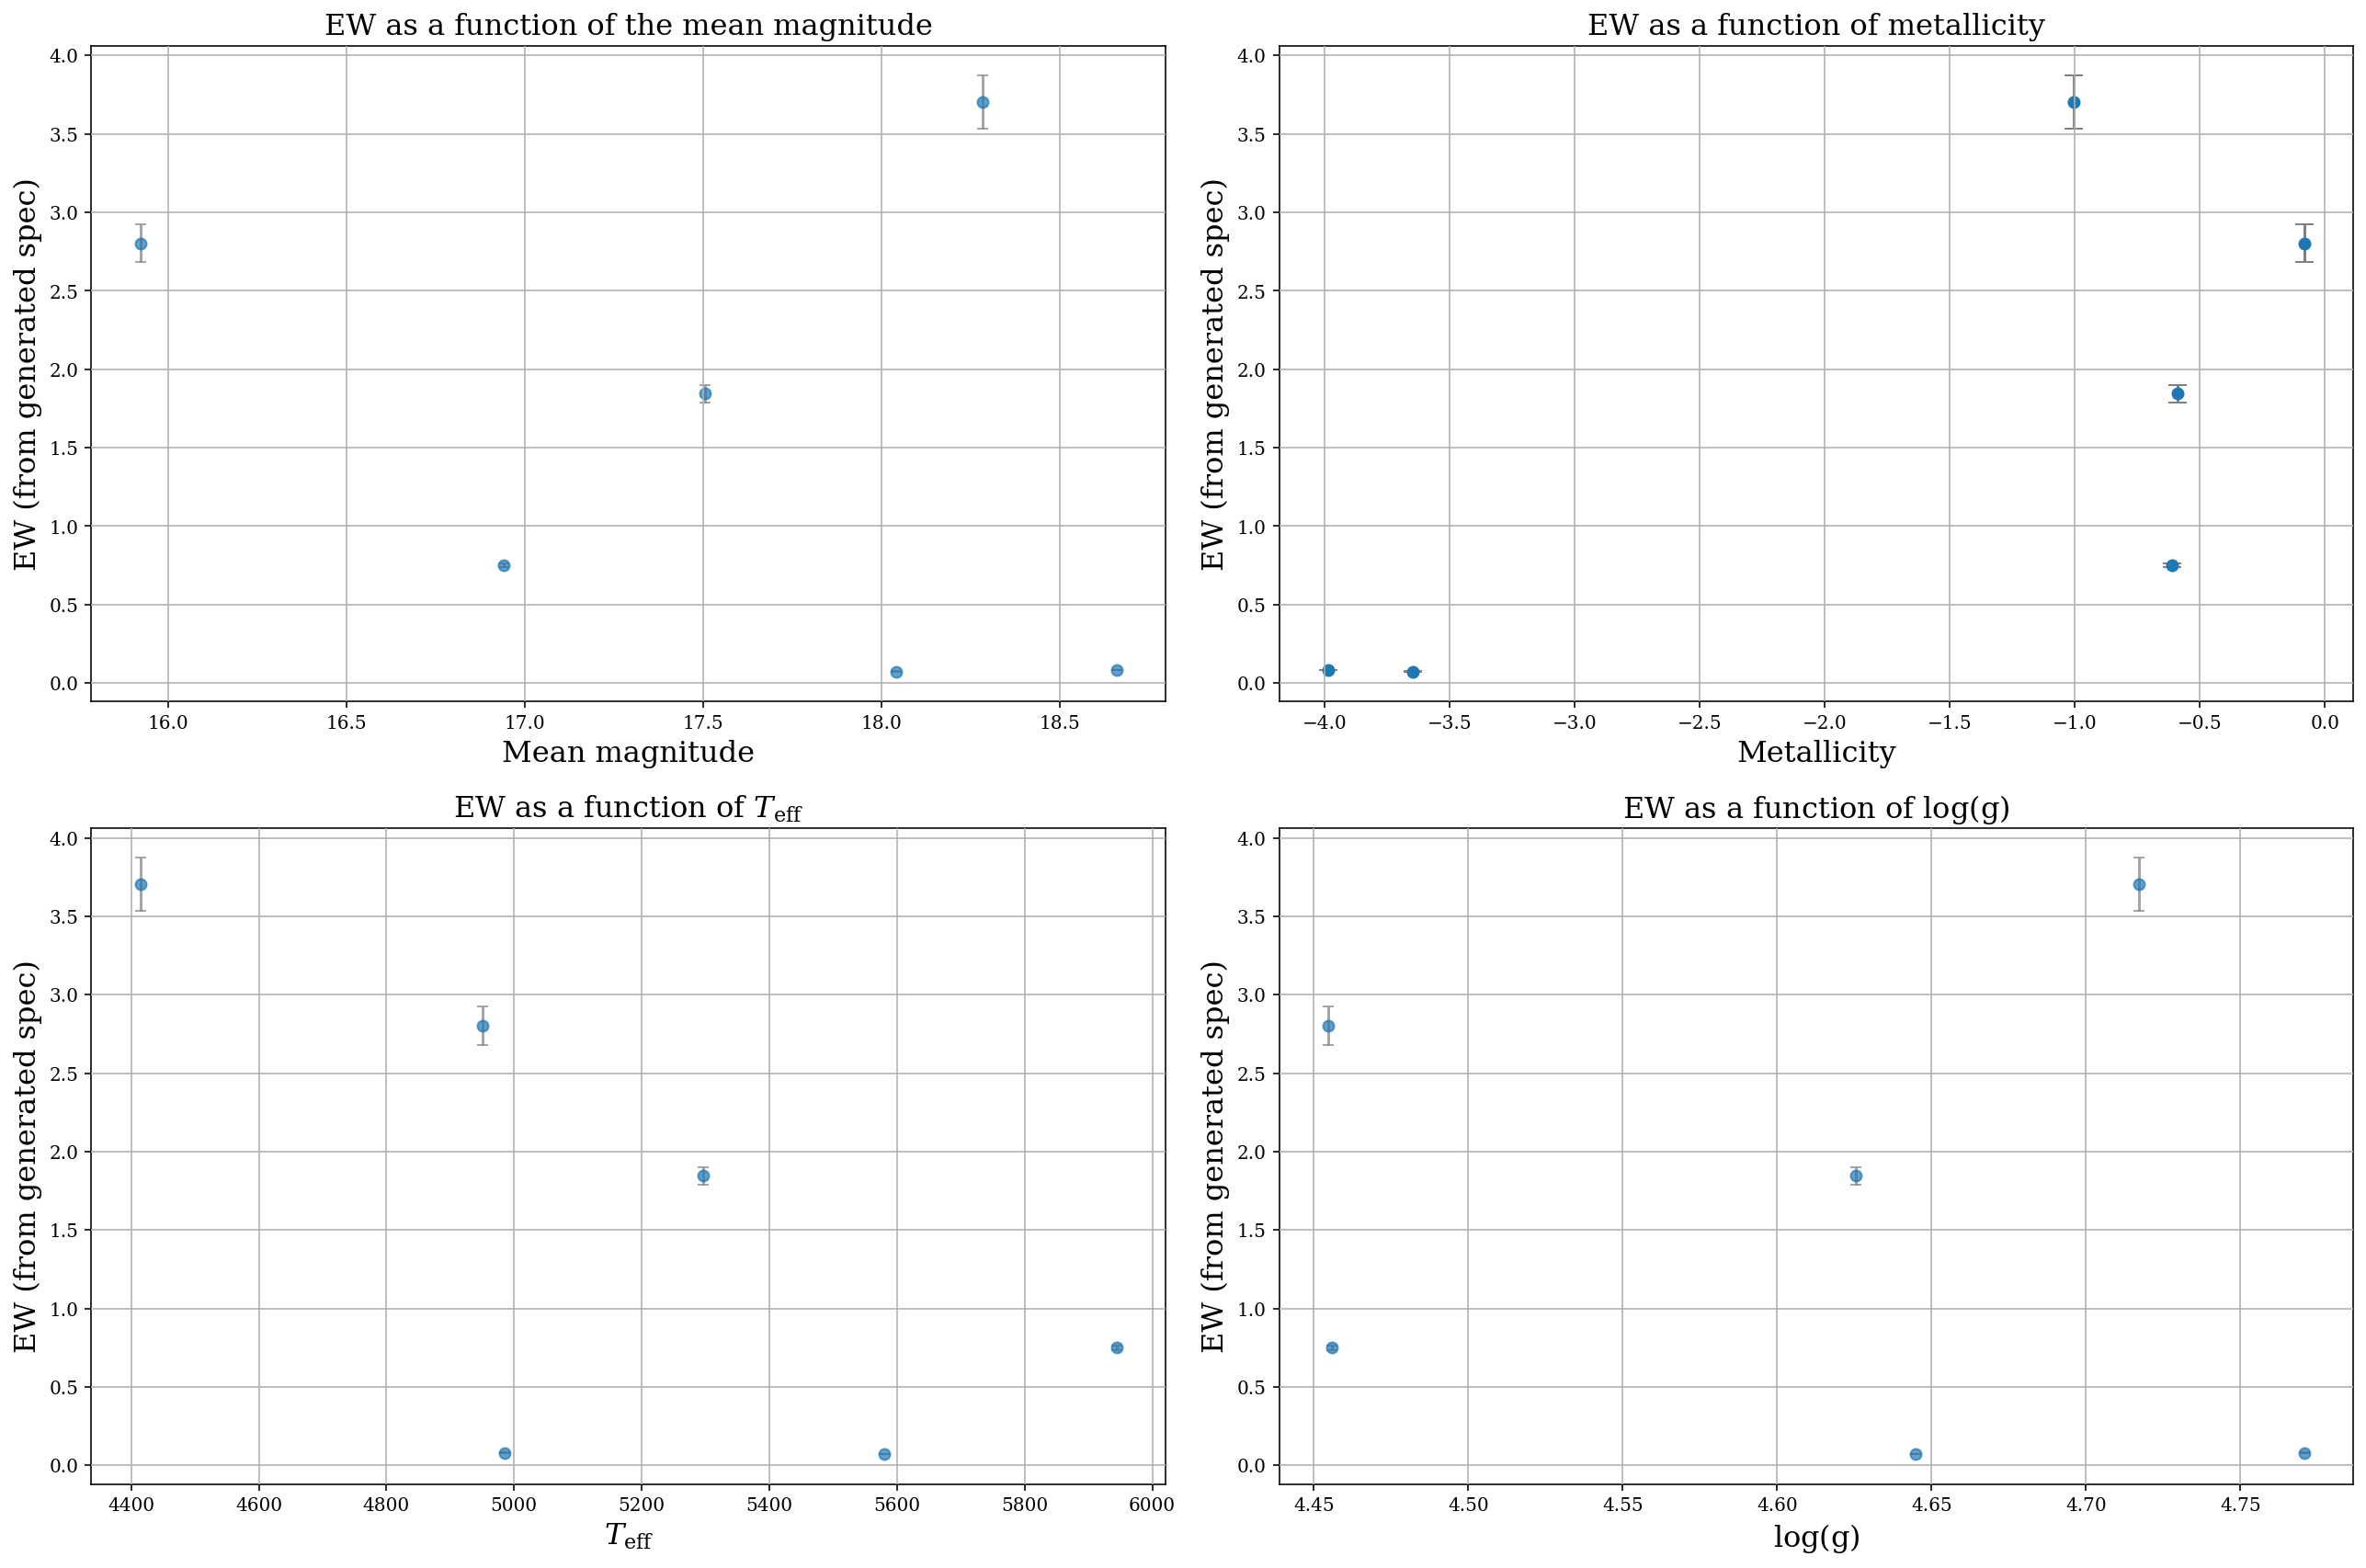

In [74]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(2, 2, figsize=(18, 12))

ax[0][0].errorbar(stars_data['mag'].values, ew, yerr=stars_data['EW_err'].values, fmt='o', ecolor='gray', alpha=0.7, capsize=3)


ax[0][0].set_title("EW as a function of the mean magnitude", fontsize=16)
ax[0][0].set_xlabel("Mean magnitude", fontsize=16)
ax[0][0].set_ylabel("EW (from generated spec)", fontsize=16)
ax[0][0].grid(True)

#######

ax[0][1].errorbar(stars_data['met'].values, ew, yerr=stars_data['EW_err'].values, fmt='o', ecolor='gray', capsize=5)


ax[0][1].set_title("EW as a function of metallicity", fontsize=16)
ax[0][1].set_xlabel("Metallicity", fontsize=16)
ax[0][1].set_ylabel("EW (from generated spec)", fontsize=16)
ax[0][1].grid(True)

#######

ax[1][0].errorbar(stars_data['teff'].values, ew, yerr=stars_data['EW_err'].values, fmt='o', ecolor='gray', alpha=0.7, capsize=3)
ax[1][0].set_title("EW as a function of $T_{\mathrm{eff}}$", fontsize=16)
ax[1][0].set_xlabel("$T_{\mathrm{eff}}$", fontsize=16)
ax[1][0].set_ylabel("EW (from generated spec)", fontsize=16)
ax[1][0].grid(True)

#######

ax[1][1].errorbar(stars_data['logg'].values, ew, yerr=stars_data['EW_err'].values, fmt='o', ecolor='gray', alpha=0.7, capsize=3)


ax[1][1].set_title("EW as a function of $\log(\mathrm{g})$", fontsize=16)
ax[1][1].set_xlabel("$\log(\mathrm{g})$", fontsize=16)
ax[1][1].set_ylabel("EW (from generated spec)", fontsize=16)
ax[1][1].grid(True)

plt.tight_layout()
plt.show()

[0.00085534 0.06299666 0.02694302 0.05032883 0.00361208 0.01315141]


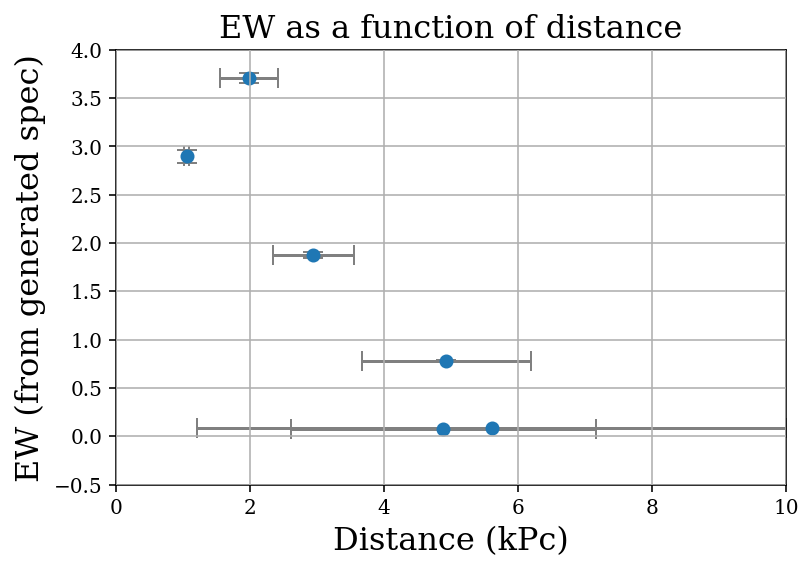

In [181]:
distance = 1 / stars_data['parallax'].values
ew = stars_data['EW'].values
distance_uncertainty = (stars_data['parallax_err'].values / stars_data['parallax'].values**2)

plt.errorbar(distance, ew, xerr=distance_uncertainty,yerr=stars_data['EW_err'].values, fmt='o', ecolor='gray', capsize=5)
plt.title("EW as a function of distance", fontsize=16)
plt.xlabel("Distance (kPc)", fontsize=16)
plt.ylabel("EW (from generated spec)", fontsize=16)
plt.grid(True)
plt.xlim(0,10)
plt.ylim(-0.5,4)

print(stars_data['EW_err'].values)

Plotting the observed EW - theoretical EW

In [78]:
stack_all(cube[:,107-5:107+5,352-5:352+5])

array([[168613.67, 174638.88, 180586.72, 185288.06, 188043.36, 190553.98,
        188834.94, 183092.44, 172555.06, 160870.77],
       [178628.27, 188471.69, 198041.48, 209382.05, 218328.47, 222928.83,
        220976.23, 213486.11, 197284.78, 180677.78],
       [189346.95, 204072.86, 222272.11, 243395.6 , 262996.25, 275940.53,
        273189.47, 258539.45, 232476.81, 205886.38],
       [200469.8 , 223993.69, 254533.19, 296553.47, 343536.94, 373343.97,
        369332.9 , 333015.66, 283069.34, 238403.56],
       [217458.64, 251665.44, 301022.1 , 372970.53, 457925.03, 501546.75,
        481963.  , 418015.22, 338643.78, 272437.75],
       [227189.06, 267725.84, 339446.03, 447878.94, 584730.9 , 670938.  ,
        636511.6 , 513566.94, 393691.44, 304561.34],
       [228261.1 , 275782.5 , 358711.03, 491123.16, 648074.6 , 743940.5 ,
        700346.6 , 554397.1 , 415082.78, 314773.56],
       [223890.77, 267308.78, 339209.47, 449480.7 , 578816.2 , 650726.56,
        605120.1 , 493280.38, 378289.

In [75]:
positions=np.transpose((stars_data['x'].values,stars_data['y'].values))

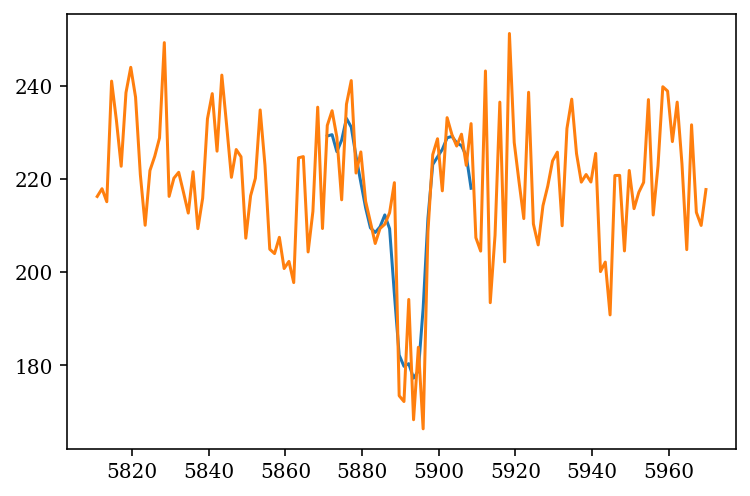

EW= 1.21  +/-  0.2105659433568178


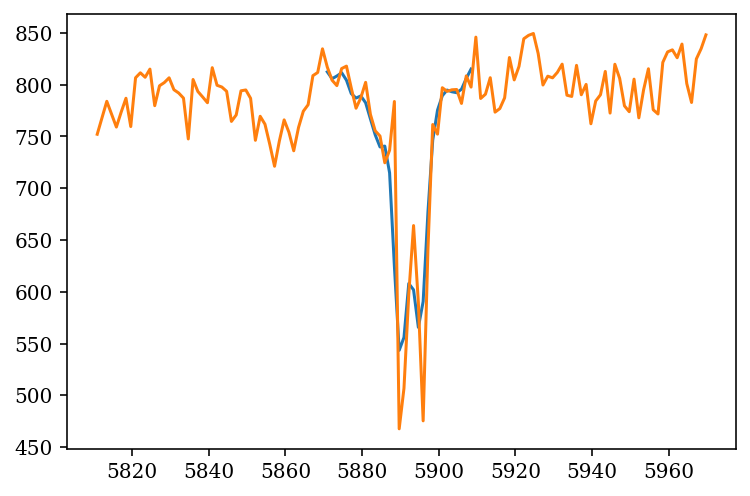

EW= 2.87  +/-  0.17719872906283765


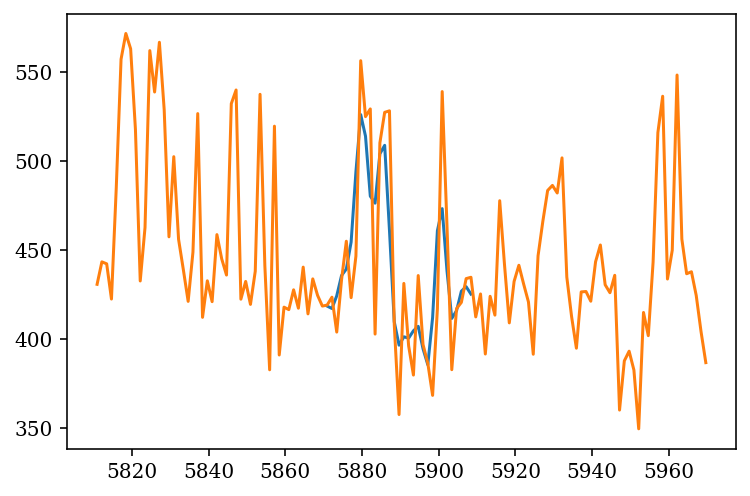

EW= -0.47  +/-  0.28549137330127394


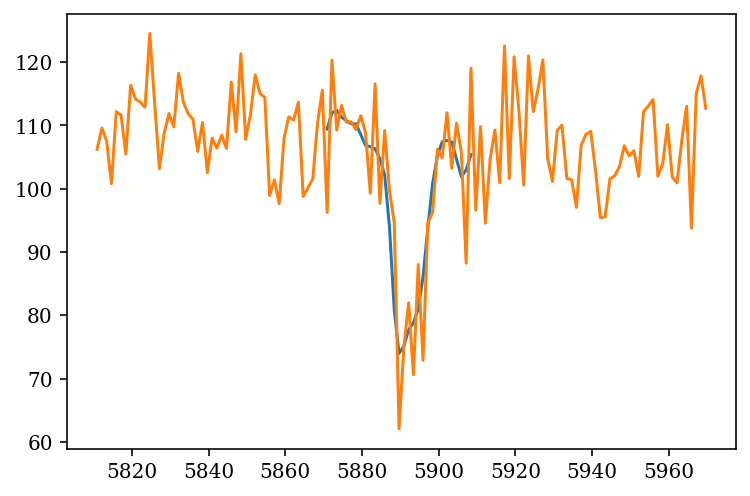

EW= 2.61  +/-  0.1957649947805174


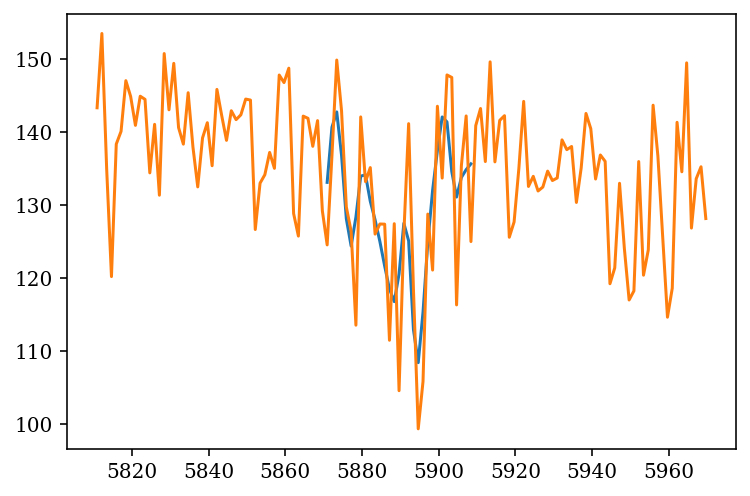

EW= 1.48  +/-  0.19815736948623364


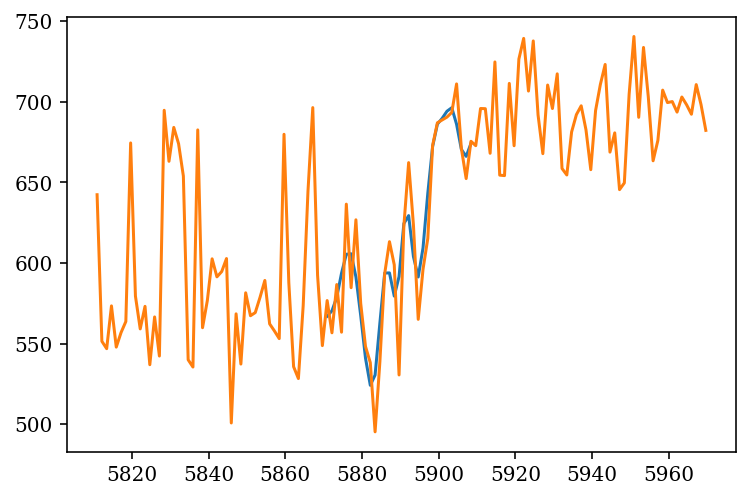

EW= 0.48  +/-  0.2862284226382247


In [224]:
EWs,err=EW_point_sources(cube, positions, wave, na_rest,plots=True)

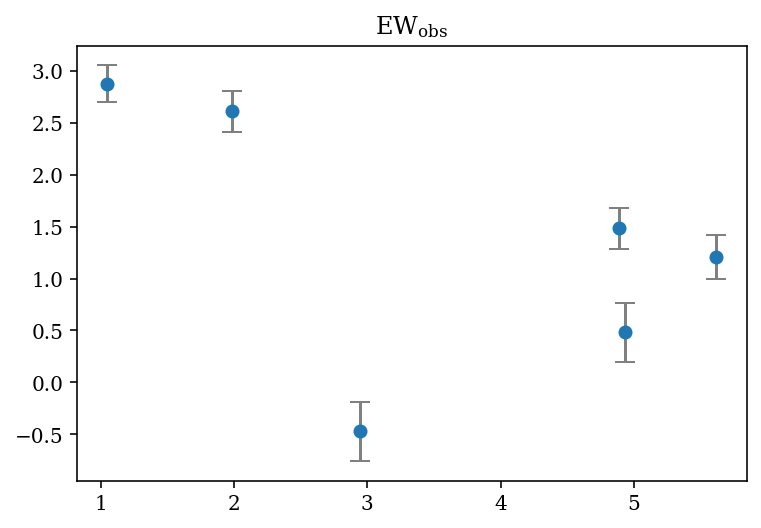

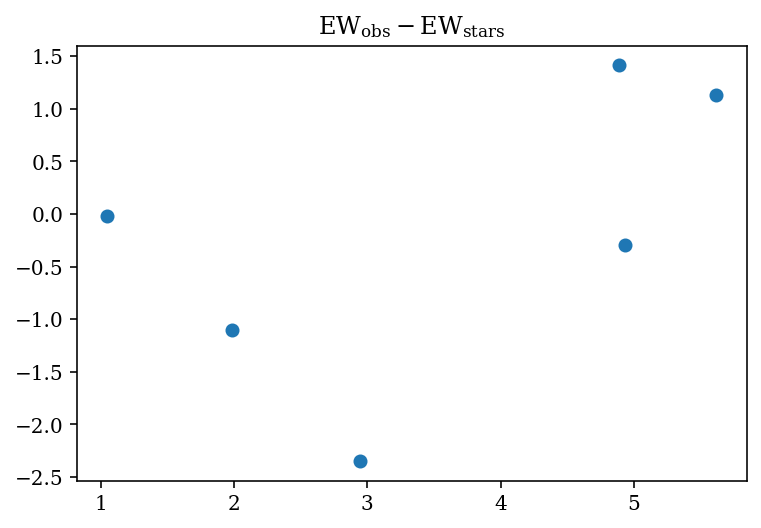

In [226]:
#plt.scatter(1/stars_data['parallax'].values,EWs)

plt.errorbar(1/stars_data['parallax'].values,EWs,yerr=err, fmt='o', ecolor='gray', capsize=5)

plt.title("$\mathrm{EW_{obs}}$")
plt.show()
plt.scatter(1/stars_data['parallax'].values,np.subtract(EWs,stars_data['EW'].values))
plt.title("$\mathrm{EW_{obs}}-\mathrm{EW_{stars}}$")
plt.show()

## Model dependencies on parameters Teff, met, logg

In [216]:
"""teff = np.array(range(4400,6000,50))
met = [-0.5] * len(teff)
logg = [4.6] * len(teff)
par = [0.3] * len(teff)"""

# teff between 4400-6000, -4<met<0, 4<logg<5, par
L=50
N=int((6000-4400)/50)
teff = np.tile(np.array(range(4400,6000,N)),5)
met = [-4] * L + [-3] * L + [-2] * L + [-1] * L + [0] * L
logg = [4.6] * L + [4.6] * L +[4.6] * L + [4.6] * L + [4.6] * L
par = [0.3] * L + [0.3] * L +[0.3] * L + [0.3] * L + [0.3] * L


stars_data = pd.DataFrame({
    'parallax': par,     # Parallax
    'teff': teff,        # Effective temperature
    'logg': logg,        # Surface gravity
    'met': met,          # Metallicity
})

In [217]:
specs=generate_spectra(model,stars_data,figures=False)
ew_theoretical=[]
err_ew_theoretical=[]
for (wavelength, flux) in specs:
    val=EW_theoretical_spectra(wavelength*10000, flux,5893,plots=False);
    
    ew_theoretical.append(val[0][0])
    err_ew_theoretical.append(val[1][0])

    
stars_data['EW'] = ew_theoretical
stars_data['EW_err'] = err_ew_theoretical

EW= 0.27  +/-  0.0015700530842876238
EW= 0.23  +/-  0.0012973806193623582
EW= 0.21  +/-  0.0009621902914568514
EW= 0.18  +/-  0.0006763037296743739
EW= 0.17  +/-  0.0006458390124187183
EW= 0.15  +/-  0.0006400370570691771
EW= 0.14  +/-  0.0005390698224172874
EW= 0.13  +/-  0.00046590333887206196
EW= 0.12  +/-  0.0003941450699258686
EW= 0.12  +/-  0.00033664899502059884
EW= 0.11  +/-  0.0002947387300154199
EW= 0.10  +/-  0.0002036795696758226
EW= 0.10  +/-  0.000157135114808288
EW= 0.10  +/-  0.00011019164832745814
EW= 0.09  +/-  0.00014817060652485523
EW= 0.09  +/-  0.00020514108150457768
EW= 0.09  +/-  0.0003018425335120435
EW= 0.08  +/-  0.00031143959667822397
EW= 0.08  +/-  0.0003602441084345119
EW= 0.08  +/-  0.00042059444405207413
EW= 0.08  +/-  0.00045997478927621013
EW= 0.07  +/-  0.0004972756237647632
EW= 0.07  +/-  0.0005437081898040342
EW= 0.06  +/-  0.000631829756645312
EW= 0.06  +/-  0.0006971741845622288
EW= 0.06  +/-  0.0007719008224833992
EW= 0.06  +/-  0.000849882108446

EW= 2.06  +/-  0.07737959826615085
EW= 1.99  +/-  0.07311696801989977
EW= 1.91  +/-  0.06904693988256624
EW= 1.85  +/-  0.06517098209996115
EW= 1.80  +/-  0.061313185014301025
EW= 1.72  +/-  0.057763862361993754
EW= 1.67  +/-  0.05445449174541395
EW= 1.61  +/-  0.05130587649445806
EW= 1.55  +/-  0.0482971989465557
EW= 1.51  +/-  0.04539541974904202
EW= 1.46  +/-  0.04266435692468496
EW= 1.41  +/-  0.040221915679600796
EW= 1.37  +/-  0.038414747137006905
EW= 1.33  +/-  0.03685012103602699
EW= 1.30  +/-  0.035261874547283564
EW= 1.26  +/-  0.033354730387026424
EW= 1.23  +/-  0.031037477220816664


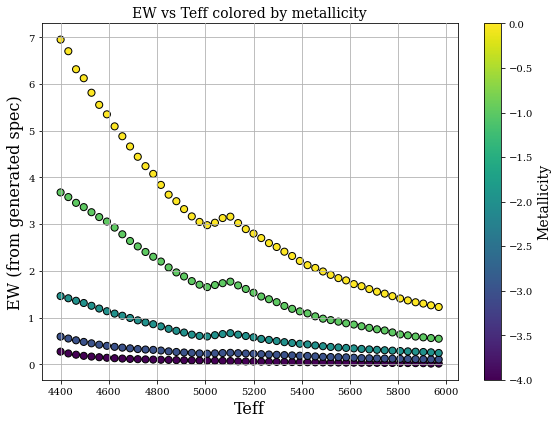

In [218]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    stars_data['teff'].values,
    stars_data['EW'].values,
    c=stars_data['met'].values,     # color by metallicity
    cmap='viridis',                 # choose a nice colormap
    s=50,                           # point size
    edgecolor='k'                   # optional: add edge for visibility
)

plt.xlabel("Teff", fontsize=16)
plt.ylabel("EW (from generated spec)", fontsize=16)
plt.title("EW vs Teff colored by metallicity", fontsize=14)


cbar = plt.colorbar(scatter)
cbar.set_label("Metallicity", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()


different plot

In [268]:
# teff between 4400-6000, -4<met<0, 4<logg<5, par
aux=np.arange(-3,1,0.5)
met = np.tile(aux,5)
teff = [5000] * len(aux) * 5
logg = [4.] * len(aux) + [4.3] * len(aux) + [4.6] * len(aux) + [4.9] * len(aux) + [5.1] * len(aux)
par = [0.3] * len(aux) * 5

stars_data = pd.DataFrame({
    'parallax': par,     # Parallax
    'teff': teff,        # Effective temperature
    'logg': logg,        # Surface gravity
    'met': met,          # Metallicity
})

EW= 0.20  +/-  0.0010846219811684028
EW= 0.34  +/-  0.002642799068427189
EW= 0.46  +/-  0.004165634484454919
EW= 0.77  +/-  0.009598203817133584
EW= 1.17  +/-  0.022406864169680435
EW= 1.61  +/-  0.04351687042834142
EW= 2.01  +/-  0.08102873415777775
EW= 2.40  +/-  0.1376302821813046
EW= 0.21  +/-  0.0010927887389414928
EW= 0.37  +/-  0.0032874896340491368
EW= 0.52  +/-  0.005293761791547372
EW= 0.88  +/-  0.013386406778880387
EW= 1.38  +/-  0.031150903145010168
EW= 1.91  +/-  0.05921854714857449
EW= 2.49  +/-  0.10312510442883077
EW= 2.82  +/-  0.16896038376932812
EW= 0.23  +/-  0.0011672835111269637
EW= 0.41  +/-  0.0038968824177304717
EW= 0.59  +/-  0.006527808705928005
EW= 1.02  +/-  0.018208528616139967
EW= 1.64  +/-  0.041301327078957624
EW= 2.26  +/-  0.07739222746382661
EW= 2.96  +/-  0.13011686841347547
EW= 3.54  +/-  0.2016491217111069
EW= 0.25  +/-  0.0013393029534877721
EW= 0.46  +/-  0.0049498029359501036
EW= 0.66  +/-  0.008283242030135071
EW= 1.17  +/-  0.023102501341172

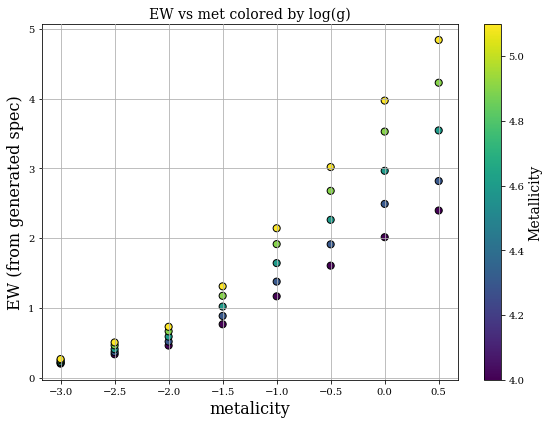

In [270]:
specs=generate_spectra(model,stars_data,figures=False)

ew_theoretical=[]
err_ew_theoretical=[]
for (wavelength, flux) in specs:
    val=EW_theoretical_spectra(wavelength*10000, flux,5893,plots=False);
    
    ew_theoretical.append(val[0][0])
    err_ew_theoretical.append(val[1][0])

    
stars_data['EW'] = ew_theoretical
stars_data['EW_err'] = err_ew_theoretical

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    stars_data['met'].values,
    stars_data['EW'].values,
    c=stars_data['logg'].values,    # color by logg
    cmap='viridis',                 # choose a nice colormap
    s=50,                           # point size
    edgecolor='k'                   # optional: add edge for visibility
)

plt.xlabel("metalicity", fontsize=16)
plt.ylabel("EW (from generated spec)", fontsize=16)
plt.title("EW vs met colored by log(g)", fontsize=14)


cbar = plt.colorbar(scatter)
cbar.set_label("Metallicity", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()

EW vs par colored by logg

In [264]:
# teff between 4400-6000, -4<met<0, 4<logg<5, par


aux=np.arange(4400,6000,50)
teff = np.tile(aux,5)
par = [0.3] * len(aux) * 5
logg = [4] * len(aux) + [4.3] * len(aux) + [4.6] * len(aux) + [4.9] * len(aux) + [5.1] * len(aux)
met = [-1] * len(aux) * 5

stars_data = pd.DataFrame({
    'parallax': par,     # Parallax
    'teff': teff,        # Effective temperature
    'logg': logg,        # Surface gravity
    'met': met,          # Metallicity
})

EW= 3.15  +/-  0.11832849408671334
EW= 2.86  +/-  0.10427130476664825
EW= 2.63  +/-  0.08888658533511395
EW= 2.38  +/-  0.076484200940141
EW= 2.19  +/-  0.06331824408164768
EW= 2.02  +/-  0.05541216828882825
EW= 1.87  +/-  0.04771831029874995
EW= 1.73  +/-  0.04148123345907333
EW= 1.59  +/-  0.03566793032418838
EW= 1.48  +/-  0.03131722458924183
EW= 1.37  +/-  0.027289313400617025
EW= 1.24  +/-  0.02455045791833302
EW= 1.17  +/-  0.022406864169680435
EW= 1.20  +/-  0.023307363089401636
EW= 1.23  +/-  0.025281352726645025
EW= 1.16  +/-  0.022492401163086567
EW= 1.08  +/-  0.020148097128153776
EW= 1.01  +/-  0.018308280411097572
EW= 0.95  +/-  0.01650990526247923
EW= 0.89  +/-  0.015105697664452264
EW= 0.83  +/-  0.013820850637138461
EW= 0.78  +/-  0.012733811723784854
EW= 0.73  +/-  0.011637714964282557
EW= 0.68  +/-  0.01058367051624663
EW= 0.65  +/-  0.00959533793378578
EW= 0.62  +/-  0.008571279275793141
EW= 0.58  +/-  0.007854264133581139
EW= 0.53  +/-  0.007405356414038782
EW= 0.48

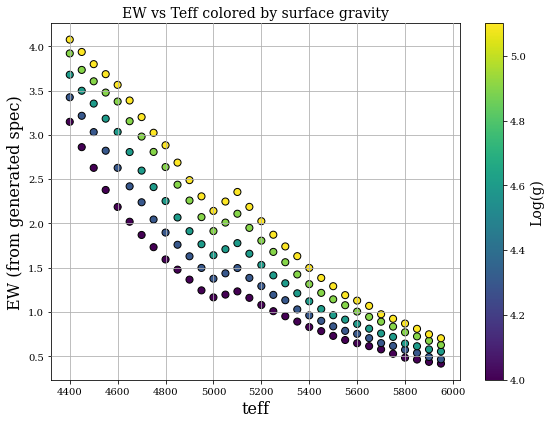

In [267]:
specs=generate_spectra(model,stars_data,figures=False)

ew_theoretical=[]
err_ew_theoretical=[]
for (wavelength, flux) in specs:
    val=EW_theoretical_spectra(wavelength*10000, flux,5893,plots=False);
    
    ew_theoretical.append(val[0][0])
    err_ew_theoretical.append(val[1][0])

    
stars_data['EW'] = ew_theoretical
stars_data['EW_err'] = err_ew_theoretical

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    stars_data['teff'].values,
    stars_data['EW'].values,
    c=stars_data['logg'].values,    # color by logg
    cmap='viridis',                 # choose a nice colormap
    s=50,                           # point size
    edgecolor='k'                   # optional: add edge for visibility
)

plt.xlabel("teff", fontsize=16)
plt.ylabel("EW (from generated spec)", fontsize=16)
plt.title("EW vs Teff colored by surface gravity", fontsize=14)


cbar = plt.colorbar(scatter)
cbar.set_label("Log(g)", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()

EW vs log colored by Teff

In [286]:
# teff between 4400-6000, -4<met<0, 4<logg<5, par


aux=np.arange(3,5,0.1)
par = [0.3] * len(aux) * 5
logg = np.tile(aux,5)
teff = [4500] * len(aux) + [4750] * len(aux) + [5000] * len(aux) + [5250] * len(aux) + [5500] * len(aux)
met = [-1] * len(aux) * 5

stars_data = pd.DataFrame({
    'parallax': par,     # Parallax
    'teff': teff,        # Effective temperature
    'logg': logg,        # Surface gravity
    'met': met,          # Metallicity
})

EW= 1.55  +/-  0.03168258943365881
EW= 1.62  +/-  0.037394520458290906
EW= 1.72  +/-  0.04177387078144425
EW= 1.80  +/-  0.04518405743508328
EW= 1.90  +/-  0.04793692920772172
EW= 2.00  +/-  0.05193405372280866
EW= 2.11  +/-  0.05938040366432746
EW= 2.23  +/-  0.06661098105883985
EW= 2.35  +/-  0.07502523954569928
EW= 2.50  +/-  0.08166967952316212
EW= 2.63  +/-  0.08888658533511395
EW= 2.77  +/-  0.09762001084983306
EW= 2.90  +/-  0.10363248073269275
EW= 3.03  +/-  0.11358693860514449
EW= 3.16  +/-  0.1204697378874987
EW= 3.28  +/-  0.12523528161162872
EW= 3.35  +/-  0.1306410803796188
EW= 3.42  +/-  0.13986054499504935
EW= 3.52  +/-  0.14961334242070573
EW= 3.60  +/-  0.1602850523943411
EW= 1.10  +/-  0.016885983823109338
EW= 1.15  +/-  0.018320107906747932
EW= 1.19  +/-  0.01992502965040382
EW= 1.24  +/-  0.02143368838298548
EW= 1.29  +/-  0.023461251689275965
EW= 1.35  +/-  0.025497572615760283
EW= 1.43  +/-  0.02967656213644354
EW= 1.50  +/-  0.033514942134831964
EW= 1.57  +/-  0.

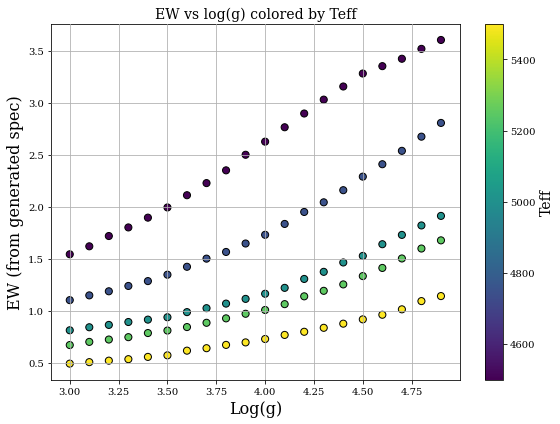

In [287]:
specs=generate_spectra(model,stars_data,figures=False)

ew_theoretical=[]
err_ew_theoretical=[]
for (wavelength, flux) in specs:
    val=EW_theoretical_spectra(wavelength*10000, flux,5893,plots=False);
    
    ew_theoretical.append(val[0][0])
    err_ew_theoretical.append(val[1][0])

    
stars_data['EW'] = ew_theoretical
stars_data['EW_err'] = err_ew_theoretical

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    stars_data['logg'].values,
    stars_data['EW'].values,
    c=stars_data['teff'].values,    # color by logg
    cmap='viridis',                 # choose a nice colormap
    s=50,                           # point size
    edgecolor='k'                   # optional: add edge for visibility
)

plt.xlabel("Log(g)", fontsize=16)
plt.ylabel("EW (from generated spec)", fontsize=16)
plt.title("EW vs log(g) colored by Teff", fontsize=14)


cbar = plt.colorbar(scatter)
cbar.set_label("Teff", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()

In [288]:
from photutils.aperture import CircularAperture
aper = CircularAperture([10.0, 20.0], 3.0)
aper = CircularAperture((10.0, 20.0), 3.0)

In [289]:
aper

<CircularAperture([10., 20.], r=3.0)>